<a href="https://colab.research.google.com/github/pachterlab/BLGKP_2020/blob/master/notebooks/diagnostic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!date

Sat May  2 07:02:17 UTC 2020


In [0]:
import time
t0 = time.time()

# SwabSeq analysis

## Download files and software

### Download metadata 

In [34]:
!wget -O colab.tar.gz --quiet https://caltech.box.com/shared/static/m6t4ok1bqwuhy3f6tut9sqantufvtiro.gz
!tar -xvf colab.tar.gz

colab/
colab/parseSS.py
colab/trunc_transcriptome_11.fa
colab/SampleSheet.csv


From the SampleSheet, make the whitelist of known well barcodes. Extract relevant information as well, ie Twist RNA amount per well.

In [35]:
%%time
!chmod +x colab/parseSS.py
!colab/parseSS.py < colab/SampleSheet.csv > colab/metadata.txt
!cat colab/metadata.txt | awk '{print $1}' > colab/whitelist.txt

CPU times: user 33.7 ms, sys: 25.2 ms, total: 58.9 ms
Wall time: 3.73 s


The SampleSheet.csv has a lot of useful information that we will use downstream. 

In [36]:
!head -20 colab/SampleSheet.csv

[Header]
IEMFileVersion,5
Investigator Name,octantbio
Experiment Name,sars_run04
Date,200402
Workflow,GenerateFASTQ
Application,FASTQ Only
Instrument Type,NextSeq
Chemistry,Amplicon
[Reads]
75
[Settings]

[Data]
Plate_ID,index2,Twist_RNA_copies,ATCC_RNA_copies,ATCC_virus_copies,spike_copies,lysate,nCoV_amplicon,nCoV_primer_nM,RPP30_primer_nM,RPP30_inner_primer_nM,bc_set,RT_temp,PCR_cycles,Sample_Well,index,Sample_ID
Plate1,CAGATCTT,0.0,0.0,0.0,100,NP,N1,400,50,100,N1_S2_RPP30,64,40,A01,GAAGACTC,Plate1-A01
Plate1,TCATGACA,0.0,0.0,0.0,100,NP,N1,400,50,100,N1_S2_RPP30,64,40,A02,GAAGACTC,Plate1-A02
Plate1,CAGATCTT,0.0,0.0,0.0711273687954072,100,NP,N1,400,50,100,N1_S2_RPP30,64,40,A03,GATAGAAC,Plate1-A03
Plate1,TCATGACA,0.0,0.0,0.0711273687954072,100,NP,N1,400,50,100,N1_S2_RPP30,64,40,A04,GATAGAAC,Plate1-A04
Plate1,CAGATCTT,0.0,0.0,0.2133821063862216,100,NP,N1,400,50,100,N1_S2_RPP30,64,40,A05,TTGGCCCA,Plate1-A05


Peeking at the first two lines of the metadata and the whitelist. The metadata has columns 

`"bcs", "index1", "index2", "plate", "well", "gene", "lysate", "Twist", "ATCC_RNA", "ATCC_viral"`

If you're sample sheet changes you will need to modify how `parseSS.py` grabs data and puts it in `metadata.txt`. Note that the "barcode" is made by concatenating index 1 and index 2. This is extremely important to keep in mind because index1 and index 2 will come from either `I1.fastq.gz` or `R2.fastq.gz` after using `bclefastq` (This is usually the case but a check is warranted, see below). This is important because when the fastq files are input into `kallisto` if the order of the barcodes is correct, the whitelist barcode error correction will not find the right barcodes.

In [37]:
!head -2 colab/metadata.txt
!head -2 colab/whitelist.txt

GAAGACTCCAGATCTT	GAAGACTC	CAGATCTT	Plate1	A01	N1	NP	0.0	0.0	0.0
GAAGACTCTCATGACA	GAAGACTC	TCATGACA	Plate1	A02	N1	NP	0.0	0.0	0.0
GAAGACTCCAGATCTT
GAAGACTCTCATGACA


### Install the modified binaries

In [0]:
# Install kallisto (built from source, branch covid, and binary hosted on box)
!wget -O colab/kallisto --quiet https://caltech.box.com/shared/static/2xwhakt70yrxdlgcutth0j0pbaxwx3c5
!chmod +x colab/kallisto
#!mv kallisto /usr/local/bin/

# Install bustools (built from source, branch covid, and binary hosted on box)
!wget -O colab/bustools --quiet https://caltech.box.com/shared/static/hh3so29octu97bjxferhih3k8a8wne2x
!chmod +x colab/bustools
#!mv bustools /usr/local/bin/

### Install required python libraries

In [39]:
!pip install anndata

In [40]:
!colab/kallisto
!colab/bustools

kallisto 0.46.2

Usage: kallisto <CMD> [arguments] ..

Where <CMD> can be one of:

    index         Builds a kallisto index 
    quant         Runs the quantification algorithm 
    bus           Generate BUS files for single-cell data 
    pseudo        Runs the pseudoalignment step 
    merge         Merges several batch runs 
    h5dump        Converts HDF5-formatted results to plaintext
    inspect       Inspects and gives information about an index
    version       Prints version information
    cite          Prints citation information

Running kallisto <CMD> without arguments prints usage information for <CMD>

bustools 0.40.0

Usage: bustools <CMD> [arguments] ..

Where <CMD> can be one of: 

sort            Sort a BUS file by barcodes and UMIs
correct         Error correct a BUS file
count           Generate count matrices from a BUS file
inspect         Produce a report summarizing a BUS file
whitelist       Generate a whitelist from a BUS file
project         Project a BUS

### Download the FASTQs

In [41]:
!mkdir colab/fastqs

mkdir: cannot create directory ‘colab/fastqs’: File exists


In [0]:
!wget --quiet -O colab/fastqs/Undetermined_S0_L001_I1_001.fastq.gz https://caltech.box.com/shared/static/3i46orxgtwlaho7f9z255hplg6tvfs6h.gz
!wget --quiet -O colab/fastqs/Undetermined_S0_L001_R2_001.fastq.gz https://caltech.box.com/shared/static/lh0nyo1v95k1s7nvw4zj84yl6jwx3hpg.gz
!wget --quiet -O colab/fastqs/Undetermined_S0_L001_R1_001.fastq.gz https://caltech.box.com/shared/static/0f3h3837xvo2dcqkax67njops5s4zxz0.gz

!wget --quiet -O colab/fastqs/Undetermined_S0_L002_I1_001.fastq.gz https://caltech.box.com/shared/static/rxb4h3owka0x2deh0royge4w55u0bub5.gz
!wget --quiet -O colab/fastqs/Undetermined_S0_L002_R2_001.fastq.gz https://caltech.box.com/shared/static/2eyqb989cohgv4h00mtjj3lrn3tpgi41.gz
!wget --quiet -O colab/fastqs/Undetermined_S0_L002_R1_001.fastq.gz https://caltech.box.com/shared/static/orqpywdlryss9df49tha4i8yywlswrtj.gz

!wget --quiet -O colab/fastqs/Undetermined_S0_L003_I1_001.fastq.gz https://caltech.box.com/shared/static/0r5ezocuh9mzxxj6nsf1fgfl38fdbfye.gz
!wget --quiet -O colab/fastqs/Undetermined_S0_L003_R2_001.fastq.gz https://caltech.box.com/shared/static/d48e56j9qqxo4sveqiwa3lq9bwzxua4f.gz
!wget --quiet -O colab/fastqs/Undetermined_S0_L003_R1_001.fastq.gz https://caltech.box.com/shared/static/7q3xgu2lp2t46638c1rg569duz5kdw9a.gz

!wget --quiet -O colab/fastqs/Undetermined_S0_L004_I1_001.fastq.gz https://caltech.box.com/shared/static/pkgyve9ft7u09du66a0e3r4a3ae4mmhc.gz
!wget --quiet -O colab/fastqs/Undetermined_S0_L004_R2_001.fastq.gz https://caltech.box.com/shared/static/nvfmriwe1891lfqrvedmoko6i5sd0mm6.gz
!wget --quiet -O colab/fastqs/Undetermined_S0_L004_R1_001.fastq.gz https://caltech.box.com/shared/static/krcntl56mgt91ca08qvljfhohh9g197m.gz

Check the files

In [43]:
!zcat colab/fastqs/Undetermined_S0_L001_I1_001.fastq.gz | awk '(NR-2)%4==0' | head -2
!zcat colab/fastqs/Undetermined_S0_L001_R2_001.fastq.gz | awk '(NR-2)%4==0' | head -2
!zcat colab/fastqs/Undetermined_S0_L001_R1_001.fastq.gz | awk '(NR-2)%4==0' | head -2

GGGGGGGG
GTGCTATC
AGATCTCG
CATCTGAG
GCAGCGTTACCANGATGTTATTTCTT
TATCTTCAACCTNGGACTTTTCTATT


Check the reference sequences

In [44]:
!cat colab/trunc_transcriptome_11.fa

>SARS-CoV-2_S
ttatgtgggttatcttcaacctagga
>SARS-CoV-2_S_spikein
ttatgtgggtATAGAAcaacctagga
>SARS-CoV-2_N
ccgcattacgtttggtggaccctcag
>SARS-CoV-2_N_spikein
ccgcattacgAAACCAggaccctcag
>RPP30
agatttggacctgcgagcgggttctgacctgaaggctctgcgcggacttgtggagacagccgctc


## Processing

### Build the kallisto index 

In [45]:
%%time
!colab/kallisto index -i colab/index.idx -k 11 colab/trunc_transcriptome_11.fa


[build] loading fasta file colab/trunc_transcriptome_11.fa
[build] k-mer length: 11
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 5 contigs and contains 119 k-mers 

CPU times: user 7.46 ms, sys: 8.71 ms, total: 16.2 ms
Wall time: 1.02 s


### Align reads to this reference

In [46]:
%%time
# The SwabSeq technology expects the first index, then second, then the biological read. 
# We are only processing one lane out of 4 lanes
!colab/kallisto bus -x SwabSeq -o colab/out/ -t 2 -i colab/index.idx \
colab/fastqs/Undetermined_S0_L001_I1_001.fastq.gz \
colab/fastqs/Undetermined_S0_L001_R2_001.fastq.gz \
colab/fastqs/Undetermined_S0_L001_R1_001.fastq.gz \
colab/fastqs/Undetermined_S0_L002_I1_001.fastq.gz \
colab/fastqs/Undetermined_S0_L002_R2_001.fastq.gz \
colab/fastqs/Undetermined_S0_L002_R1_001.fastq.gz \
colab/fastqs/Undetermined_S0_L003_I1_001.fastq.gz \
colab/fastqs/Undetermined_S0_L003_R2_001.fastq.gz \
colab/fastqs/Undetermined_S0_L003_R1_001.fastq.gz \
colab/fastqs/Undetermined_S0_L004_I1_001.fastq.gz \
colab/fastqs/Undetermined_S0_L004_R2_001.fastq.gz \
colab/fastqs/Undetermined_S0_L004_R1_001.fastq.gz


[index] k-mer length: 11
[index] number of targets: 5
[index] number of k-mers: 119
[index] number of equivalence classes: 5
[quant] will process sample 1: colab/fastqs/Undetermined_S0_L001_I1_001.fastq.gz
                               colab/fastqs/Undetermined_S0_L001_R2_001.fastq.gz
                               colab/fastqs/Undetermined_S0_L001_R1_001.fastq.gz
[quant] will process sample 2: colab/fastqs/Undetermined_S0_L002_I1_001.fastq.gz
                               colab/fastqs/Undetermined_S0_L002_R2_001.fastq.gz
                               colab/fastqs/Undetermined_S0_L002_R1_001.fastq.gz
[quant] will process sample 3: colab/fastqs/Undetermined_S0_L003_I1_001.fastq.gz
                               colab/fastqs/Undetermined_S0_L003_R2_001.fastq.gz
                               colab/fastqs/Undetermined_S0_L003_R1_001.fastq.gz
[quant] will process sample 4: colab/fastqs/Undetermined_S0_L004_I1_001.fastq.gz
                               colab/fastqs/Undetermined_S0_L004

The output of kallisto is a BUS file. It is a 4 column binary file that contains a barcode, umi, equivalence class, and count column. We have no need for the UMI column.

In [47]:
%%time
!colab/bustools text -p colab/out/output.bus | head

GTGCTATCCATCTGAG	A	0	1
TAAGAAGGCAGATTAC	A	0	1
CCCTCAAAGAGGGCAT	A	1	1
CCATACTTAATCTTGC	A	0	1
GAGTCATGCAGATTAC	A	1	1
GGGGGGGGCAGCTTGC	A	4	1
ATCATCCTAGTTGCGC	A	3	1
GTGCTATCCATCTGAG	A	0	1
TGATGCAGCATCTGAG	A	1	1
GGGGGGGGAATCTTGC	A	4	1
CPU times: user 13.2 ms, sys: 7.17 ms, total: 20.4 ms
Wall time: 1.18 s


### Processing the BUS file

In [48]:
%%time
# sort the BUS file by barcode
!colab/bustools sort -t 2 -o colab/out/sort.bus colab/out/output.bus

# write sort.txt to file for barcode QC downstream
!colab/bustools text -p colab/out/sort.bus > colab/out/sort.txt

# Correct to the barcodes in the whitelist (obtained from the SampleSheet)
!colab/bustools correct -d colab/out/dump.txt -w colab/whitelist.txt -o colab/out/sort.correct.bus colab/out/sort.bus
#!colab/bustools correct -w colab/whitelist.txt -o colab/out/sort.correct.bus colab/out/sort.bus

# Sort again to sum the Amplicon counts
!colab/bustools sort -t 2 -o colab/out/sort.correct.sort.bus colab/out/sort.correct.bus

# write busfile to text output
!colab/bustools text -p colab/out/sort.correct.sort.bus > colab/out/data.txt

tcmalloc: large alloc 4294967296 bytes == 0x562821928000 @  0x7ff93bf60887 0x562820de9dbd 0x562820db3a21 0x7ff93ade0b97 0x562820db4a5a
Read in 96998281 BUS records
Read in 1222943 BUS records
Found 768 barcodes in the whitelist
Processed 1222943 BUS records
In whitelist = 2160
Corrected 1  = 50495
Corrected 2  = 0
Uncorrected  = 1170288
tcmalloc: large alloc 4294967296 bytes == 0x5556fd88a000 @  0x7f24b984d887 0x5556fb3efdbd 0x5556fb3b9a21 0x7f24b86cdb97 0x5556fb3baa5a
Read in 52655 BUS records
Read in 2499 BUS records
CPU times: user 217 ms, sys: 64.5 ms, total: 281 ms
Wall time: 1min 17s


________________________

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import anndata

from collections import defaultdict
from collections import OrderedDict


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.patches as mpatches



from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.special import expit as sigmoid

def nd(arr):
    return np.asarray(arr).reshape(-1)

# Effectivley python implementation of bustools covid (to be made)
def make_mtx(bcs, ecs, cnt, unique_ecs):
    
    bold = bcs[0]
    eold = ecs[0]
    cold = cnt[0]
    mtx = []
    
    d = defaultdict()
    #d[eold] = cold
    bold = 0
    for idx, b in enumerate(bcs):
    
        if b != bold and idx > 0:
            count = []
            for e in unique_ecs:
    
                count.append(d.get(e, 0))
            
            mtx.append(count)
            d = defaultdict()
    
        d[ecs[idx]] = cnt[idx]
    
        bold = b
    count = []
    for e in unique_ecs:
        count.append(d.get(e, 0))
    mtx.append(count)
    
    return np.asarray(mtx)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def main(X, y1, y2):
    y = np.asarray([y1, y2]).T
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=43)
    clf = LogisticRegression(random_state=43, dual=False, max_iter=1000, tol=1e-6)
    clf.fit(X_train, y_train[:,0])

    y_pred = clf.predict(X_test)
    
    # T = True, F = False, P = Positive,  N = Negative
    # Model Precision: TP/(TP+FP)
    # Model Recall: TP/(TP+FN)
    
    print("Score:     {:,.4f}".format(clf.score(X_test, y_test[:,0])))
    print("Precision: {:,.4f}".format(metrics.precision_score(y_test[:,0], y_pred)))
    print("Recall:    {:,.4f}".format(metrics.recall_score(y_test[:,0], y_pred)))
    
    w = clf.coef_[0]
    b = clf.intercept_[0]

    return (X_train, X_test, y_train, y_test, y_pred, w, b)

def plot(X, y, xidx, yidx, xlabel, ylabel, w, b):

    
    N = 1000
    r = 0.2
    
    # Get the test data
    c = nd(np.log10(y[:,1]+1))
    x = nd(X[:,xidx])
    y = nd(X[:,yidx])
    
    
    # Find the limits
    xlims = (np.min(x)*(1-r), np.max(x)*(1+r))
    ylims = (np.min(y)*(1-r), np.max(y)*(1+r))
    
    # compute boundary line
    xx = np.linspace(*xlims, len(x))
    yy = (-xx*w[xidx] - b)/w[yidx]
    
    X, Y = np.meshgrid(np.linspace(*xlims, N), np.linspace(*ylims, N))
    YY = (-X*w[xidx] - b)/w[yidx]
    
    ###############################################################
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    
    ### Scatter plot of points
    sc = ax.scatter(x, y, c = c,s=100, edgecolors="black", cmap="Greys")
    
    ### Plot boundary line
    # note that here we solve the above equation for y using the
    # coefficients and the intercept
    ax.plot(xx, yy, linestyle="--", color="black", linewidth=2, label="Log. reg. boundary")
    
    ### Plot logistic function
    # Perpendicular from the line is the probability that a sample
    # has viral RNA. This function is the logistic function and has
    # the form f(x) = 1/(1+exp(-(x-x0))) but we only care about variation
    # perpendicular to the line so we use Y and YY
    Z = sigmoid(Y-YY)
    # Since we want probability of 1 to be above the line, we do 1-Z
    cs = ax.imshow(Z, vmin = 0., vmax = 1., cmap=plt.cm.coolwarm, origin='lower', 
               extent=[*xlims, *ylims])
    
    #### Colorbar for RNA amount
    plt.colorbar(sc,  label="log10(Twist RNA + 1)")
    # Colorbar for Probability
    plt.colorbar(cs, label="Probability of + Virus")
    
    
    ###############################################################
    ## Prettying up the plot, adding 
    pos = mpatches.Patch(color="#D43F3A", label='$+$ Viral RNA')
    neg = mpatches.Patch(color="#3182bd", label='$-$ Viral RNA')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(neg); handles.append(pos)
    ax.legend(handles=handles[::-1])
    
    ax.set_xlabel("log({}+1) amplicon counts".format(xlabel))
    ax.set_ylabel("log({}+1) amplicon counts".format(ylabel))
    
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout(h_pad=1)
    ax.set_title("Logistic regression classifier on test data")
    return ax

def plot_LOD_adjusted(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b):
    x = np.exp(X_test[:,xidx])
    y = np.exp(X_test[:,yidx])
    c = pd.Series(y_test[:,0]).map(cm)
    
    xx = y_test[:,1]
    xx[xx==0] = 0.1
    # yy = y*w[yidx] + x*(w[xidx])
    yy = (y**w[yidx])/(x**(-w[xidx]))
    
    
    ax.scatter(xx, yy, c=c)
    
    ### Make the plot pretty
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    bc = ax.axhline(y=np.exp(-b), linestyle="--", label="Log. reg. boundary", color="k")
    
    ax.set_xlabel(r"Twist RNA amount")
    ax.set_ylabel(r"({}+1)^({:,.2f}) / ({}+1)^({:,.2f})".format(ylabel,w[yidx], xlabel,w[xidx]))
    
    # legend
    pos = mpatches.Patch(color="#D43F3A", label='$+$ Viral RNA')
    neg = mpatches.Patch(color="#3182bd", label='$-$ Viral RNA')
    ax.legend(handles=[pos, neg, bc])
    ax.set_title("Adjusted normalization based on logistic regression")
    return ax

def plot_LOD_normal(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b):
    x = np.exp(X_test[:,xidx])
    y = np.exp(X_test[:,yidx])
    c = pd.Series(y_test[:,0]).map(cm)
    
    xx = y_test[:,1]
    xx[xx==0] = 0.1
    yy = y/x
    
    ax.scatter(xx, yy, c=c)
    
    ### Make the plot pretty
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"Twist RNA amount")
    ax.set_ylabel(r"({}+1) / ({}+1))".format(ylabel, xlabel))
    
    # legend
    pos = mpatches.Patch(color="#D43F3A", label='$+$ Viral RNA')
    neg = mpatches.Patch(color="#3182bd", label='$-$ Viral RNA')
    ax.legend(handles=[pos, neg])
    
    ax.set_title("Standard normalization")
    return ax

cm = {1:"#D43F3A", 0:"#3182bd"}
fsize=15

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

## Load results

### Load the BUS file in text format

In [0]:
data_path = "colab/out/"
df = pd.read_csv(data_path + "data.txt", sep="\t", header=None, names=["bcs", "umi", "ecs", "cnt"])
df = df.sort_values("bcs")

In [51]:
df.head()

,bcs,umi,ecs,cnt
0,AACGACATAATCTTGC,A,0,14176
1,AACGACATAATCTTGC,A,1,2146
2,AACGACATAATCTTGC,A,3,1
3,AACGACATAATCTTGC,A,4,98
4,AACGACATAGTTGCGC,A,2,241


In [52]:
print("We recovered {:,} reads total".format(df.cnt.sum()))

We recovered 74,232,418 reads total


### Genes from our reference

In [0]:
gene = pd.read_csv(data_path + "/transcripts.txt", header=None, names = ["gene"])

In [54]:
gene

,gene
0,SARS-CoV-2_S
1,SARS-CoV-2_S_spikein
2,SARS-CoV-2_N
3,SARS-CoV-2_N_spikein
4,RPP30


### Plate Metadeta
(from the SampleSheet)

In [55]:
# I switch index 1 and index 2 since they are swapped in the BUS file
pmap = pd.read_csv("colab/metadata.txt", sep="\t", header=None, names=["bcs", "i1", "i2", "plate", "well", "gene", "lysate", "Twist", "ATCC_RNA", "ATCC_viral"], index_col=0)
pmap["bcs"] = pmap["i1"] + pmap["i2"]
pmap.index = pmap["bcs"]
pmap.head()

,i1,i2,plate,well,gene,lysate,Twist,ATCC_RNA,ATCC_viral,bcs
bcs,,,,,,,,,,
GAAGACTCCAGATCTT,GAAGACTC,CAGATCTT,Plate1,A01,N1,NP,0.0,0.0,0.000000,GAAGACTCCAGATCTT
GAAGACTCTCATGACA,GAAGACTC,TCATGACA,Plate1,A02,N1,NP,0.0,0.0,0.000000,GAAGACTCTCATGACA
GATAGAACCAGATCTT,GATAGAAC,CAGATCTT,Plate1,A03,N1,NP,0.0,0.0,0.071127,GATAGAACCAGATCTT
GATAGAACTCATGACA,GATAGAAC,TCATGACA,Plate1,A04,N1,NP,0.0,0.0,0.071127,GATAGAACTCATGACA
TTGGCCCACAGATCTT,TTGGCCCA,CAGATCTT,Plate1,A05,N1,NP,0.0,0.0,0.213382,TTGGCCCACAGATCTT


### Filter BUS, add metadata

In [0]:
#nodup = df.drop_duplicates("bcs")
nodup = df
nodup = nodup.sort_values("bcs")
nodup["plate"] = nodup["bcs"].map(pmap["plate"])
nodup["well"] = nodup["bcs"].map(pmap["well"])
nodup["lysate"] = nodup["bcs"].map(pmap["lysate"])
nodup["gene"] = nodup["bcs"].map(pmap["gene"])
nodup["Twist"] = nodup["bcs"].map(pmap["Twist"])
nodup["ATCC_RNA"] = nodup["bcs"].map(pmap["ATCC_RNA"])
nodup["ATCC_viral"] = nodup["bcs"].map(pmap["ATCC_viral"])

# Drop the barcodes that do not have metadata (keep only ones in the platemap)
nodup = nodup.loc[nodup["ATCC_RNA"].dropna().index].sort_values("bcs")

In [57]:
print("Plate 1 contains {:,} reads".format(nodup[nodup["plate"] == "Plate1"]["cnt"].sum()))

Plate 1 contains 31,846,632 reads


In [58]:
print("Plate 2 contains {:,} reads".format(nodup[nodup["plate"] == "Plate2"]["cnt"].sum()))

Plate 2 contains 42,385,786 reads


### Make well x gene matrix

In [0]:
# Well by gene matrix
bcs = nodup.bcs.values
ecs = nodup.ecs.values
cnt = nodup.cnt.values

unique_ecs = np.unique(ecs)

In [0]:
mtx = make_mtx(bcs, ecs, cnt, unique_ecs)

In [61]:
# A sanity check that we didn't make a mistake in make_mtx
nodup.cnt.sum() == mtx.sum()

True

In [0]:
# We only need the relevant per sample metadata so we can drop everything else
nodup = nodup.drop_duplicates("bcs")

____________________

### Make anndata object

In [63]:
adata = anndata.AnnData(X=mtx, obs = nodup, var = gene)

Transforming to str index.
Transforming to str index.


In [0]:
adata.obs["Twist_bool"] = np.logical_and(adata.obs.ATCC_viral.values==0, adata.obs.ATCC_RNA.values==0)
adata.obs["ATCC_viral_bool"] = np.logical_and(adata.obs.Twist.values==0, adata.obs.ATCC_RNA.values==0)
adata.obs["ATCC_RNA_bool"] = np.logical_and(adata.obs.Twist.values==0, adata.obs.ATCC_viral.values==0)

### Normalize counts

Scale to counts per million units (CPM), Log1p, Scale columns

In [0]:
adata.layers["raw"] = adata.X
scale_num = 1000000
adata.layers["norm"] = normalize(adata.X, norm="l1", axis=1)*scale_num
adata.layers["log1p"] = np.log1p(adata.layers["norm"])
adata.uns = OrderedDict([("log1p", {"base":None})])
adata.X = adata.layers["log1p"]
adata.layers["scale"] = scale(adata.layers["log1p"], axis=0, with_mean=True, with_std=True, copy=True)
adata.X = adata.layers["scale"]

## Quality control

### Make PCA

In [66]:
%%time
# PCA
X = adata.layers["scale"]

tsvd = TruncatedSVD(n_components=2)
adata.obsm["X_pca"] = tsvd.fit_transform(X)

CPU times: user 4.72 ms, sys: 40.6 ms, total: 45.3 ms
Wall time: 86.7 ms


The most variation is captured between plates

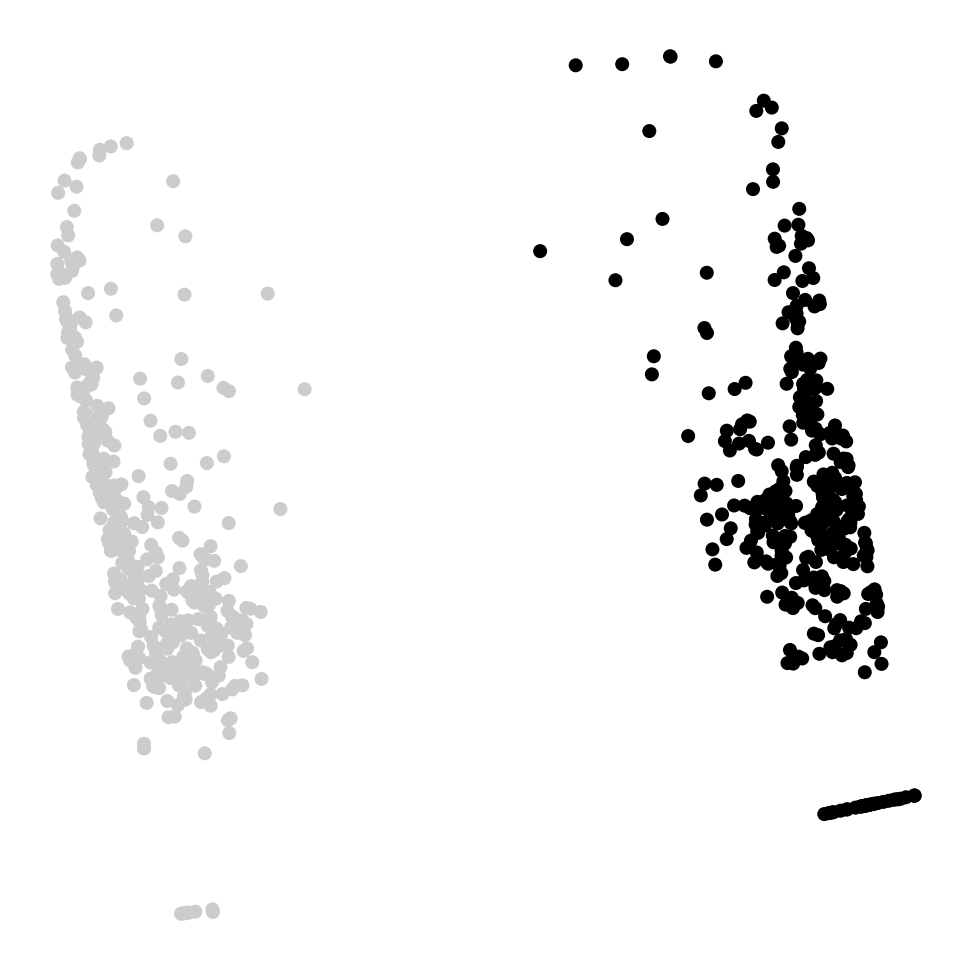

In [67]:
fig, ax = plt.subplots(figsize=(7,7))

x = adata.obsm["X_pca"][:,0]
y = adata.obsm["X_pca"][:,1]
c = adata.obs["plate"].astype("category").cat.codes.astype(int)

ax.scatter(x, y, c = c, cmap='nipy_spectral')

ax.set_axis_off()

plt.tight_layout()
plt.show()

### Barcode QC

### An example of an abberant barcode

In [68]:
gene

,gene
0,SARS-CoV-2_S
1,SARS-CoV-2_S_spikein
2,SARS-CoV-2_N
3,SARS-CoV-2_N_spikein
4,RPP30


In [0]:
s = pd.read_csv("colab/out/sort.txt", header=None, names=["bcs", "umi", "ecs", "cnt"], sep="\t")
s = s[s["ecs"] == 4]
m = pd.read_csv("colab/out/dump.txt", header=None, names=["old", "new"], sep="\t")
m = m.sort_values("new")

In [0]:
m["plate"]      = m["new"].map(pmap["plate"])
m["plate"]      = m["new"].map(pmap["plate"])
m["well"]       = m["new"].map(pmap["well"])
m["lysate"]     = m["new"].map(pmap["lysate"])
m["gene"]       = m["new"].map(pmap["gene"])
m["Twist"]      = m["new"].map(pmap["Twist"])
m["ATCC_RNA"]   = m["new"].map(pmap["ATCC_RNA"])
m["ATCC_viral"] = m["new"].map(pmap["ATCC_viral"])

m["old_cnt"] = m["old"].map(s.groupby("bcs")["cnt"].sum())
m["new_cnt"] = m["new"].map(s.groupby("bcs")["cnt"].sum())
m = m.dropna(subset=["old_cnt"])

In [0]:
bad = m[m["old_cnt"] > m["new_cnt"]]

In [72]:
bad[bad["new"] == "AGCCAAGAGAGGGCAT"]

,old,new,plate,well,lysate,gene,Twist,ATCC_RNA,ATCC_viral,old_cnt,new_cnt
11254,CGCCAAGAGAGGGCAT,AGCCAAGAGAGGGCAT,Plate2,E11,NP,S2,0.0,48.010974,0.0,9563.0,3.0


In [73]:
!bustools text -p colab/out/sort.bus | grep AGCCAAGAGAGGGCAT

/bin/bash: bustools: command not found


In [74]:
!bustools text -p colab/out/sort.bus | grep CGCCAAGAGAGGGCAT

/bin/bash: bustools: command not found


   9625 CGCCAAGA GAGGGCAT
   2689 CGCCAAGA AAGGGCAT 
    341 AGCCAAGA GAGGGCAT <-- "real"
    107 ACCCAAGA GAGGGCAT
     94 CGCCAAGA TAGGGCAT
     59 AGCCAAAA GAGGGCAT 
     28 CGCCAAGA GAGGGCTT
     13 CGCCAAGA GAGGGCAG
     10 CGCCAAGA CAGGGCAT
      9 AGCCAACA GAGGGCAT

## Diagnostic testing

### Testing by logistic regression 
We begin with the Plate2, HEK293 lysate, Twist RNA, S gene samples. Analysis of the other HEK293 lysate samples follows.

In [75]:
a = np.logical_and((adata.obs.plate=="Plate2").values, (adata.obs.lysate=="HEK293").values)
b = np.logical_and(a, adata.obs.ATCC_RNA.values==0)
c = np.logical_and(b, adata.obs.ATCC_viral.values==0)

data = adata[b]

data.obs["sick"] = (data.obs.Twist>0).astype(int)
data = data[:,np.logical_or(~data.var.gene.str.contains("N"), data.var.gene.str.contains("RPP30"))]
#data = data[:,data.var.sort_values("gene").index]

X = np.log1p(data.layers["raw"])
y1 = nd(data.obs.sick.values.astype(int))
y2 = nd(data.obs.Twist.values)

Trying to set attribute `.obs` of view, copying.


We split our data in half. We train a logistic regression model on the training half, and test out our model on the testing half. 
For the sake of downstream plotting, we append the Twist RNA values to the real classificaation for each sample to make a  `sample x 2` matrix. This results in y_test having two columns. When splitting the data into training and testing the Twist RNA values associated with the split samples are retained. Since `n_samples > n_genes` we set dual=False in the logistic regresion classification since we are not interested in solving using the dual formulation of the regularization. The equation of the line is $w_1*x + w_2*y = b$.

In [76]:
(X_train, X_test, y_train, y_test, y_pred, w, b) = main(X, y1, y2)

Score:     0.9583
Precision: 0.9474
Recall:    0.9474


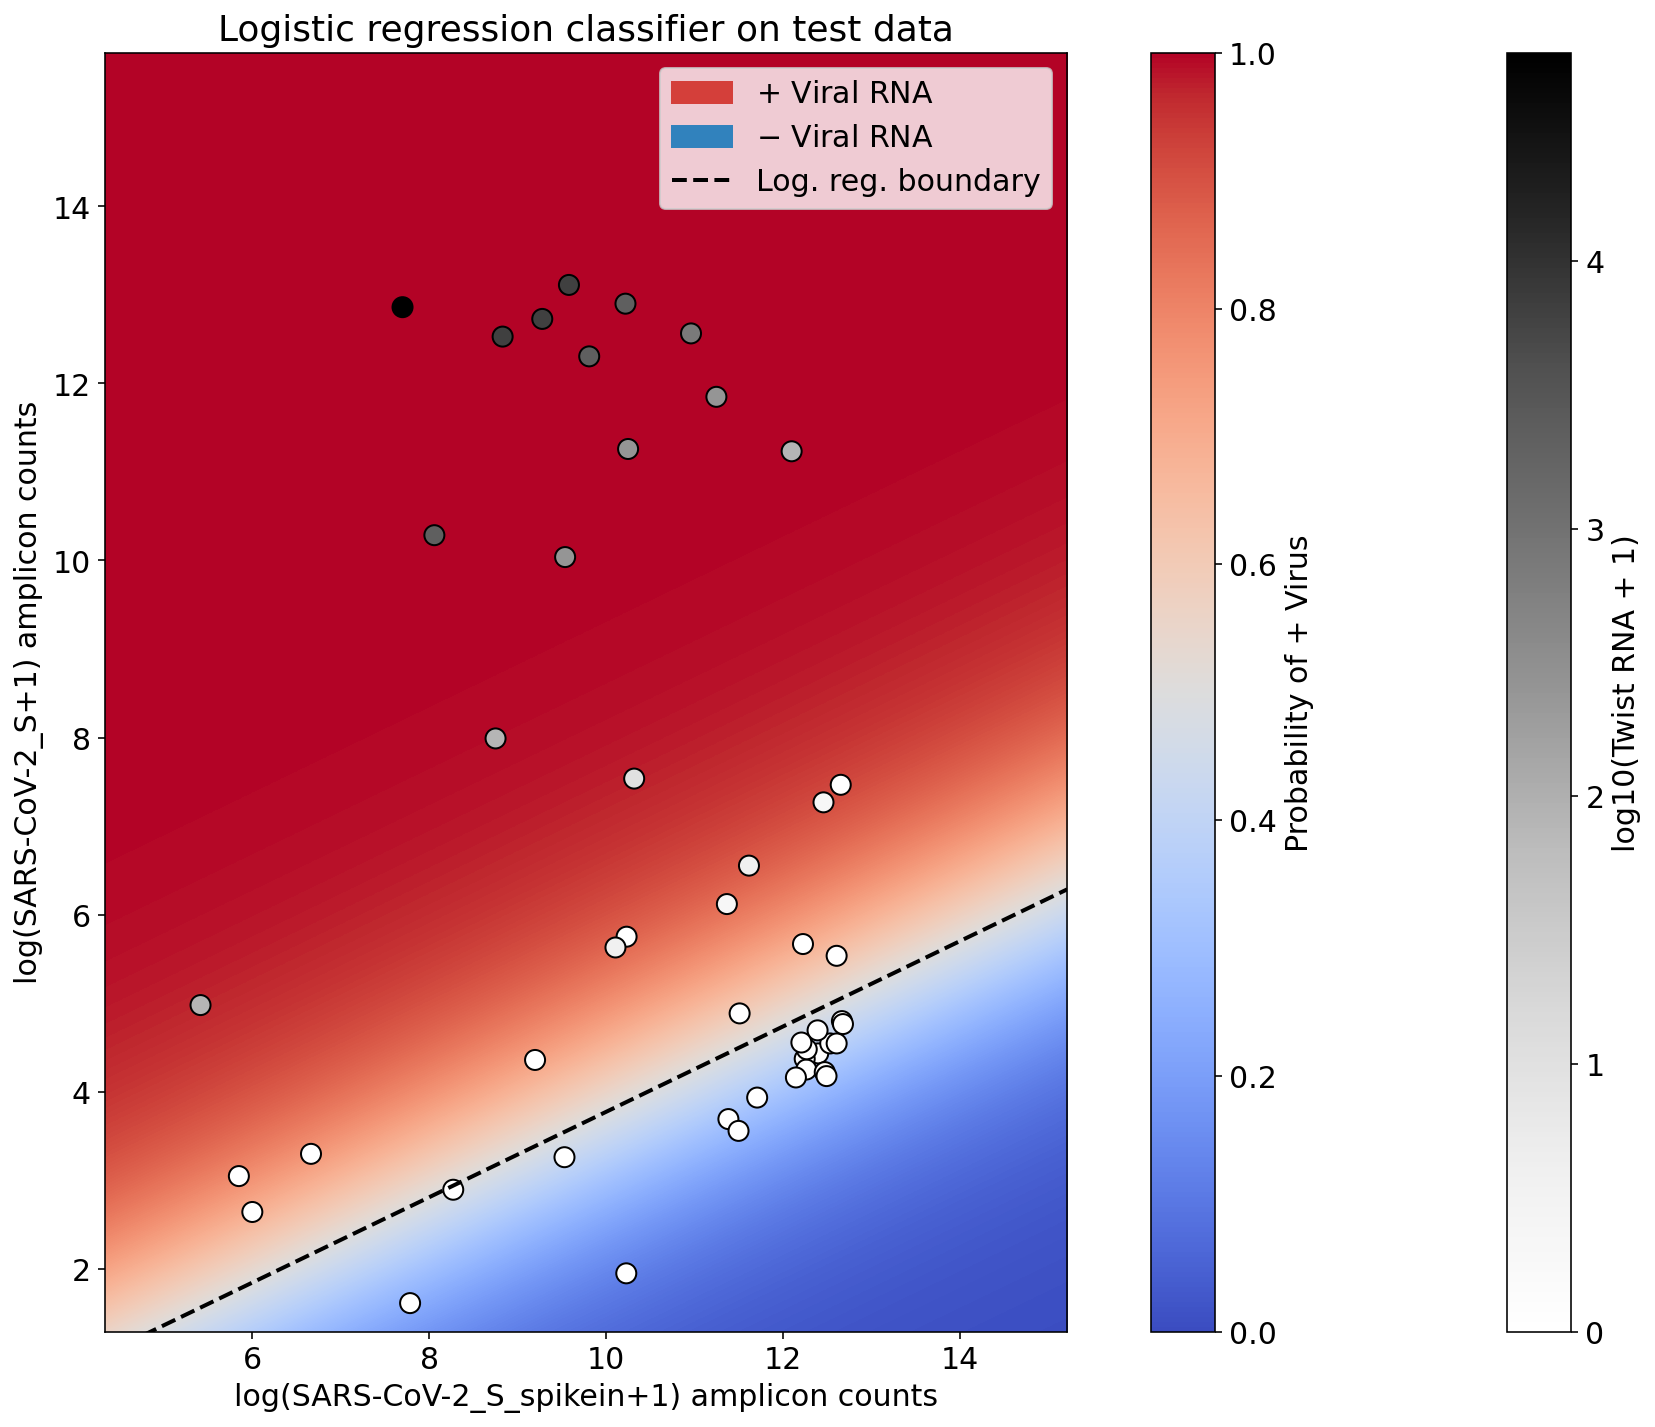

In [77]:
fig, ax = plt.subplots(figsize=(15,10))

xlabel, ylabel = ("SARS-CoV-2_S_spikein", "SARS-CoV-2_S")
xidx, yidx = (np.where(data.var.gene.values==xlabel)[0][0], np.where(data.var.gene.values==ylabel)[0][0])
    
plot(X_test, y_test, xidx, yidx, xlabel, ylabel, w, b)

plt.show()

### Examine relative counts

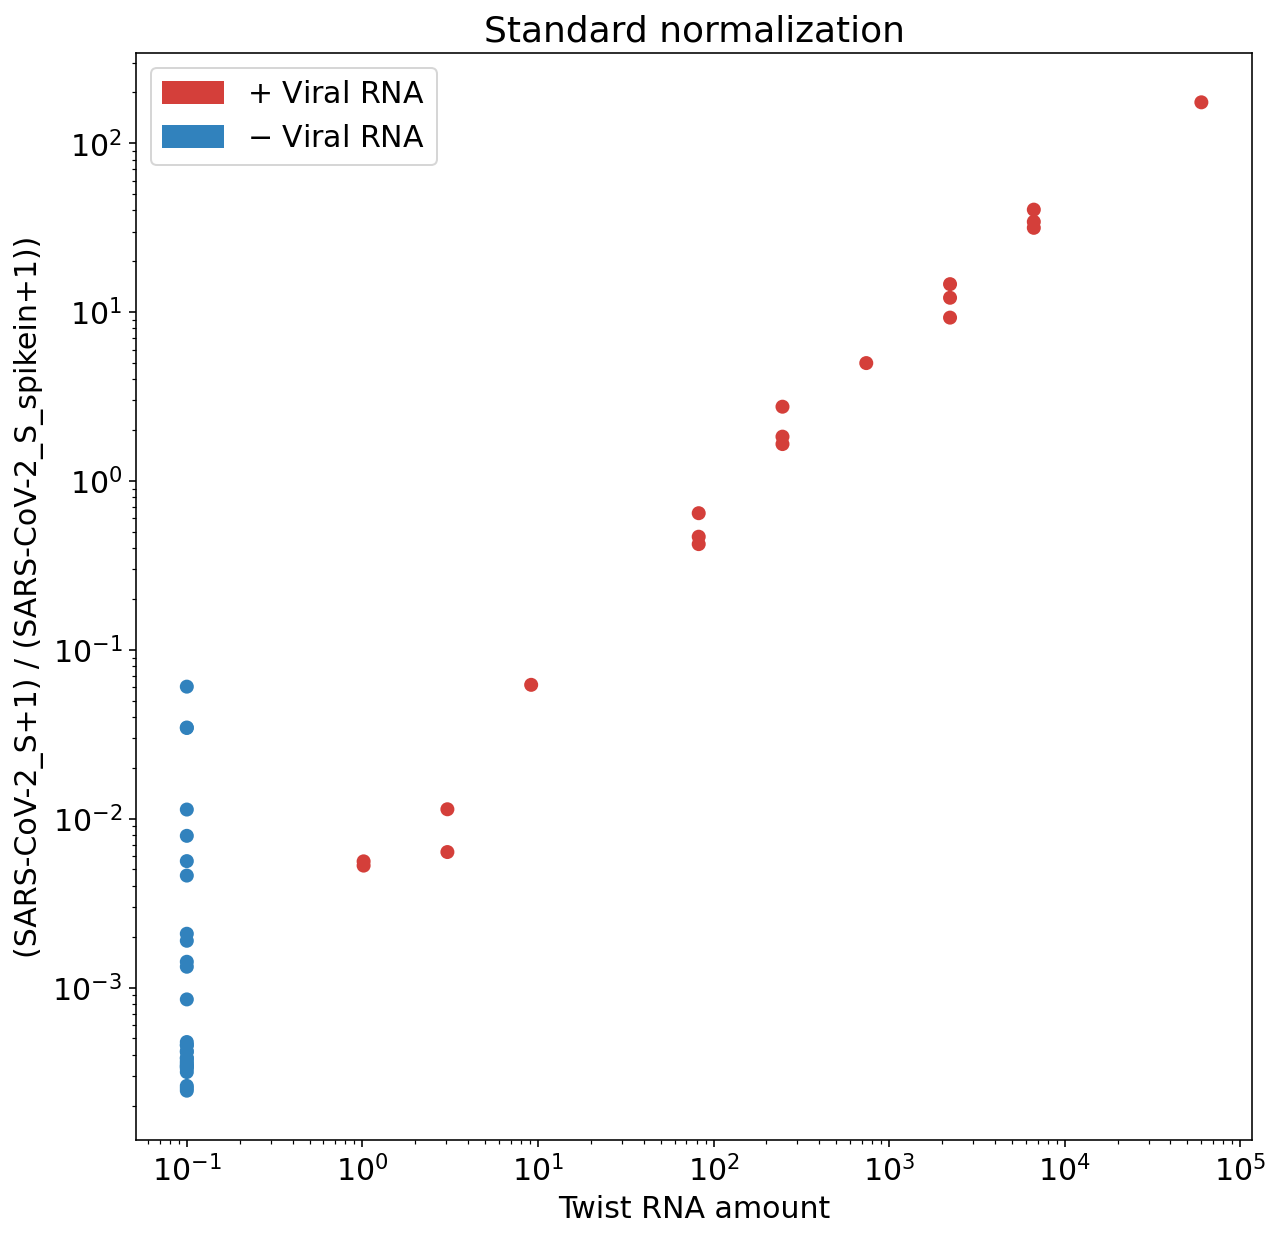

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))

xlabel, ylabel = ("SARS-CoV-2_S_spikein", "SARS-CoV-2_S")
xidx, yidx = (np.where(data.var.gene.values==xlabel)[0][0], np.where(data.var.gene.values==ylabel)[0][0])

plot_LOD_normal(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b)
plt.show()

### Adjusted relative abundances

The logistic regression was performed on the log(X+1) counts and the train/test/split gives back matrices that are log(X+1). In order to make plotting nicer (ie loglog scale axis), we exponentiate the matrices. Given $X_l = \log(X+1)$  we wish to plot $\frac{(Y+1)^{w_2}}{(X+1)^{w_1}}$ vs the amount of Twist RNA. We can plot $\frac{(Y+1)^{w_2}}{(X+1)^{w_1}} = \frac{exp(Y_l)^{w_2}}{exp(X_l)^{w_1}}$ vs the amount of Twist RNA. 

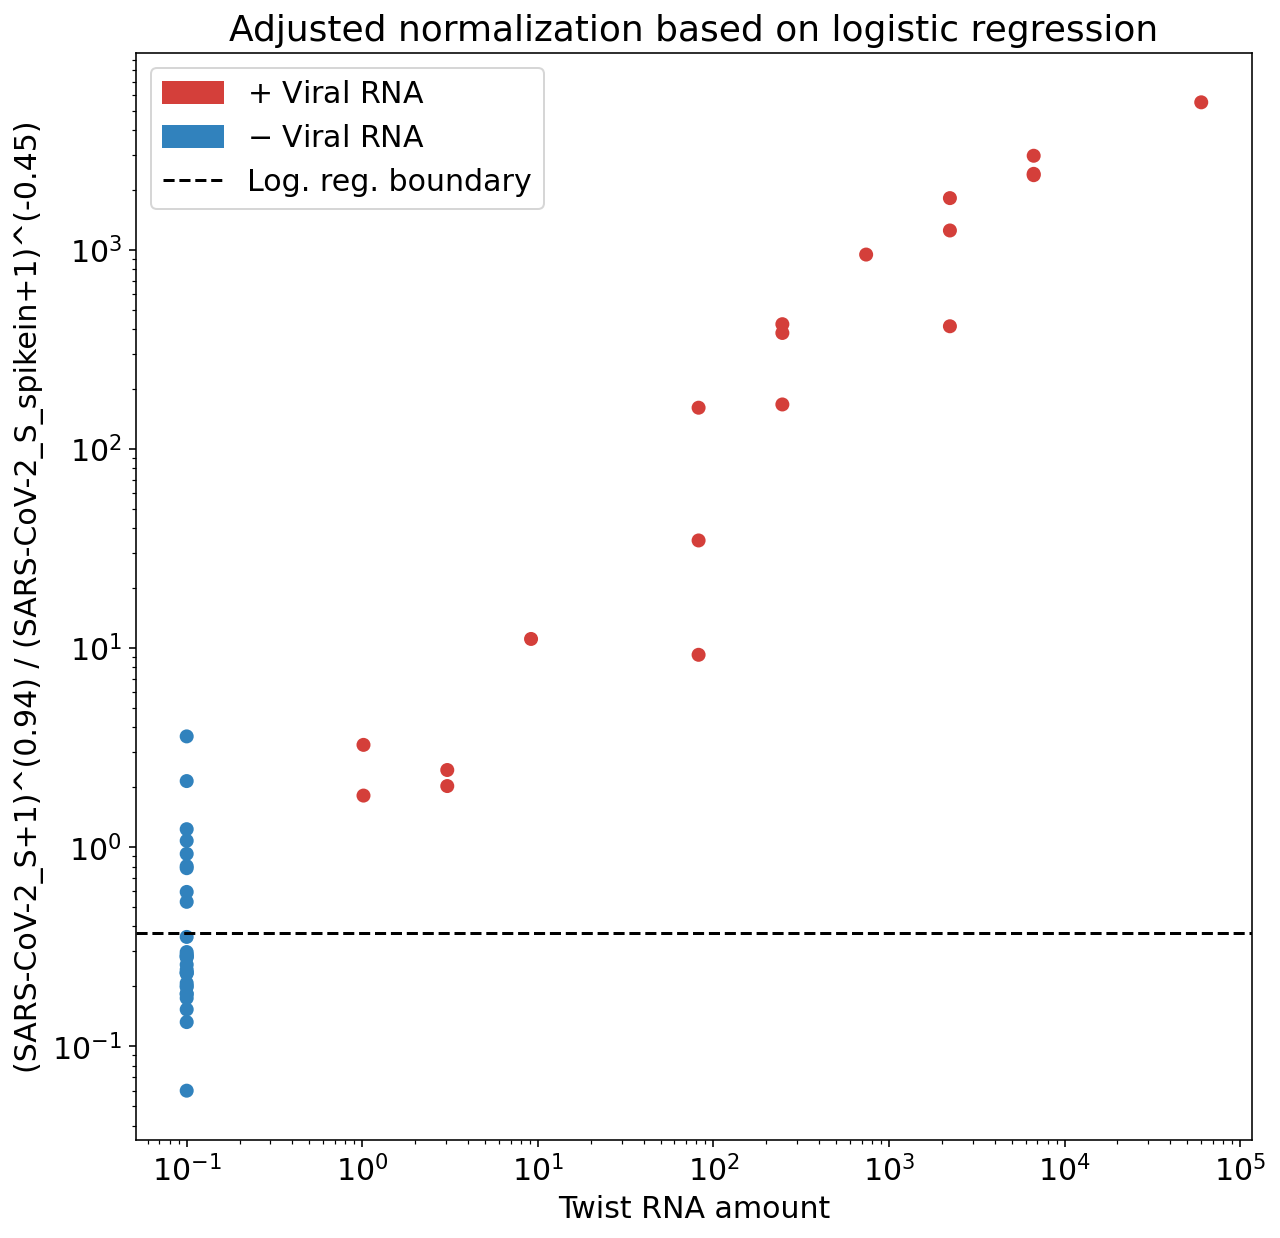

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))

xlabel, ylabel = ("SARS-CoV-2_S_spikein", "SARS-CoV-2_S")
xidx, yidx = (np.where(data.var.gene.values==xlabel)[0][0], np.where(data.var.gene.values==ylabel)[0][0])

plot_LOD_adjusted(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b)
plt.show()

### Other HEK experiments

In [0]:
exp = [
        ("Plate1", "HEK293", "N", "Twist"), 
        ("Plate1", "HEK293", "N", "ATCC_RNA"),
        ("Plate2", "HEK293", "S", "Twist"), 
        ("Plate2", "HEK293", "S", "ATCC_RNA"),
]

Plate1	HEK293	N	Twist
Score:     0.8542
Precision: 0.8000
Recall:    0.8421


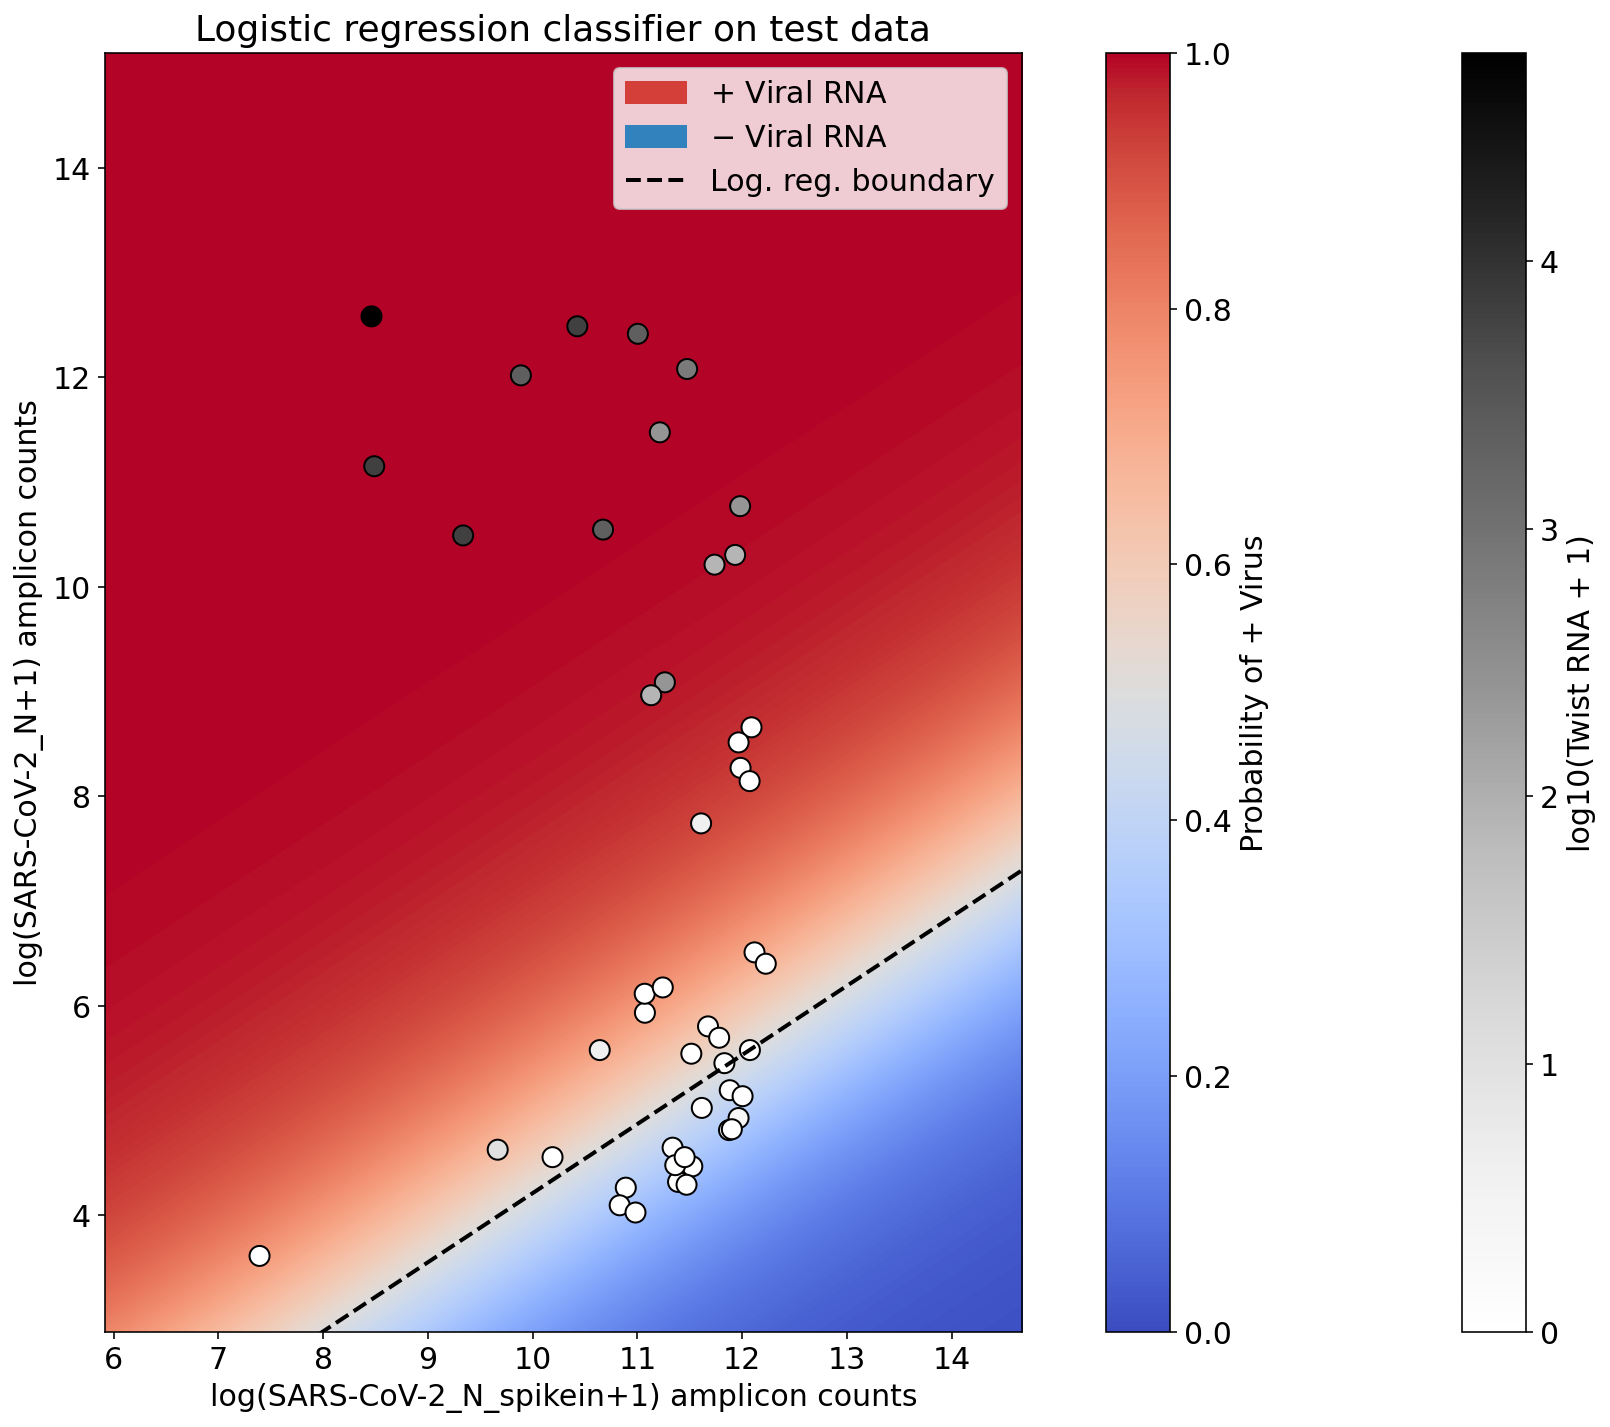

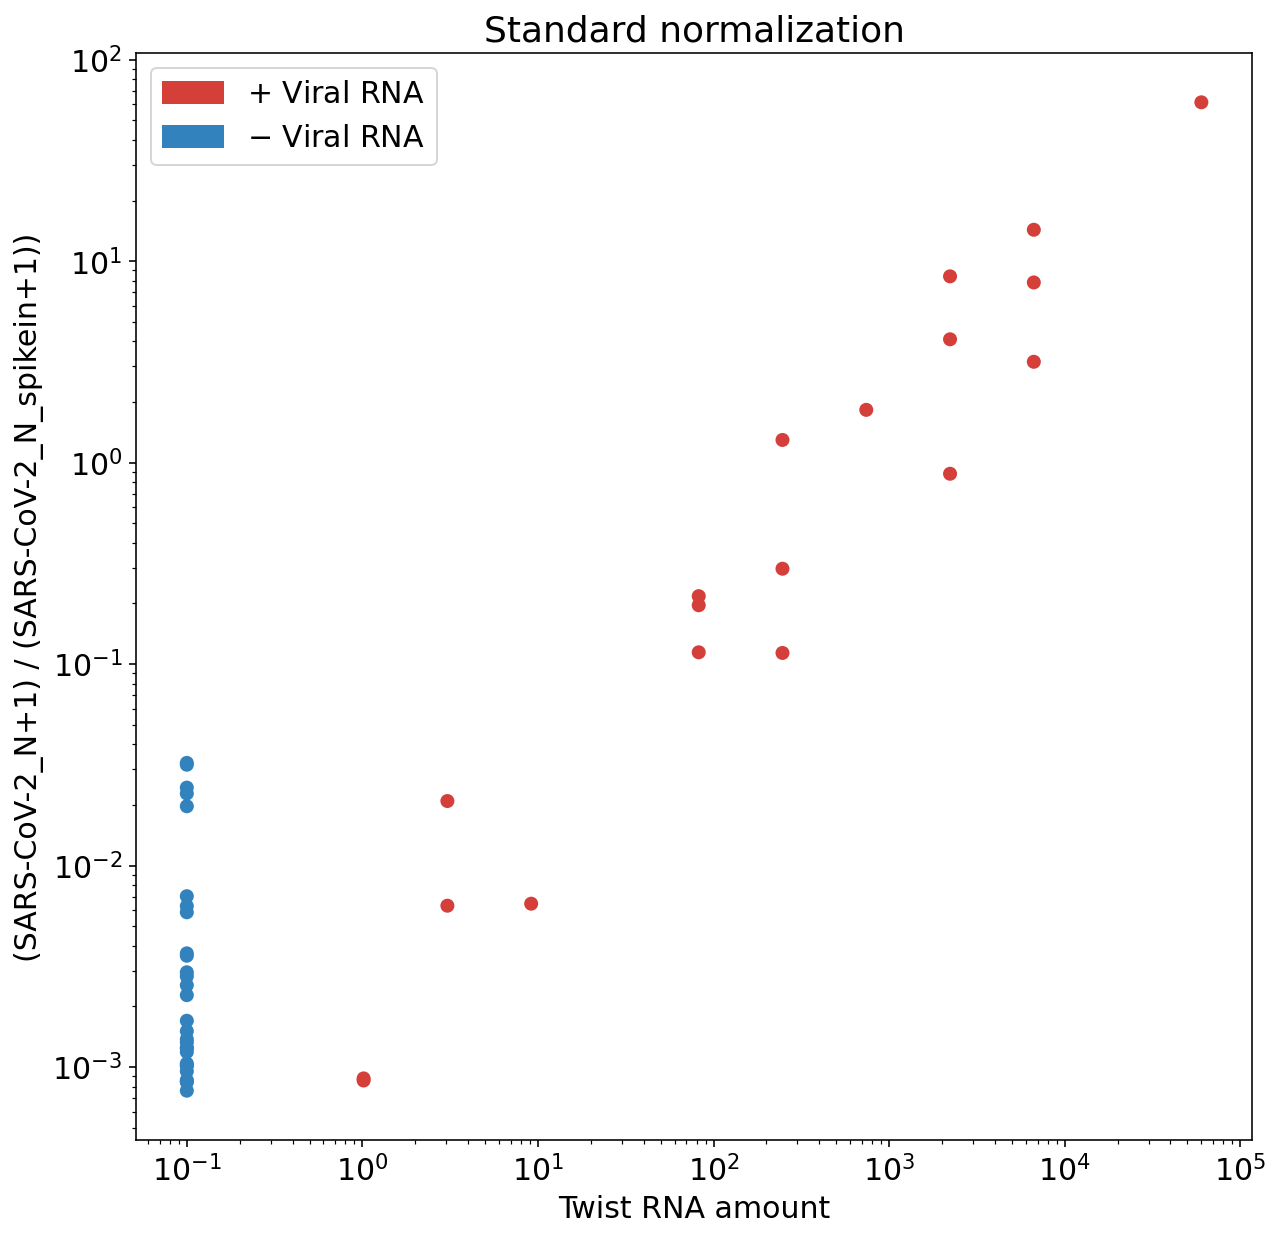

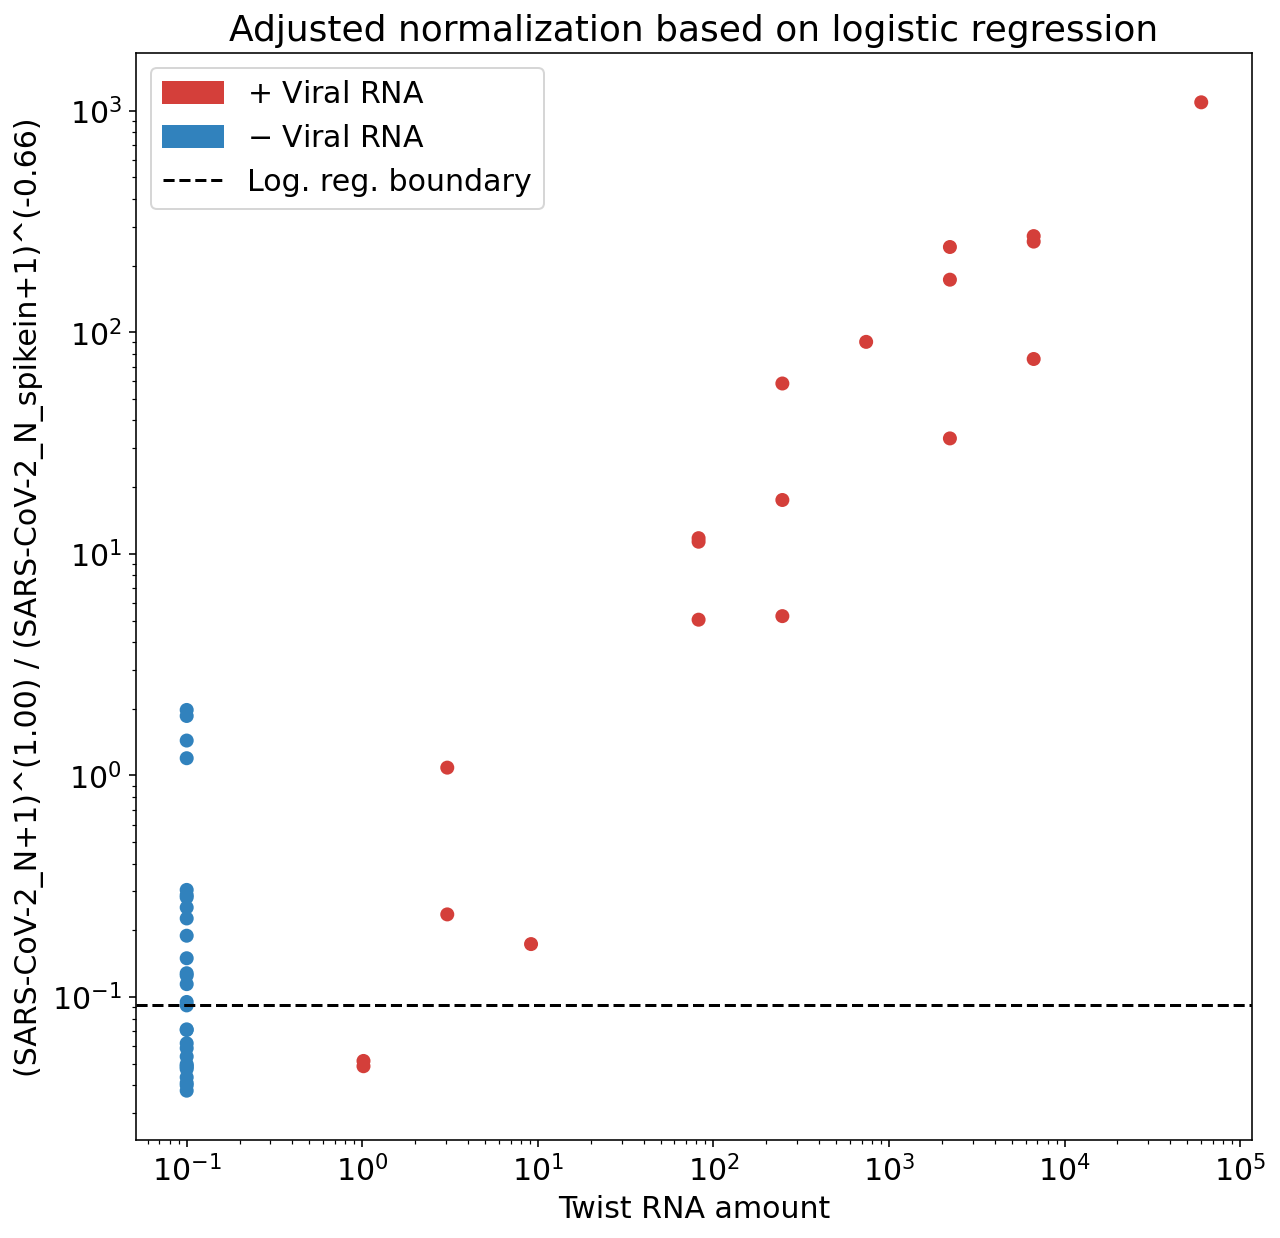

Plate1	HEK293	N	ATCC_RNA
Score:     0.9571
Precision: 1.0000
Recall:    0.9388


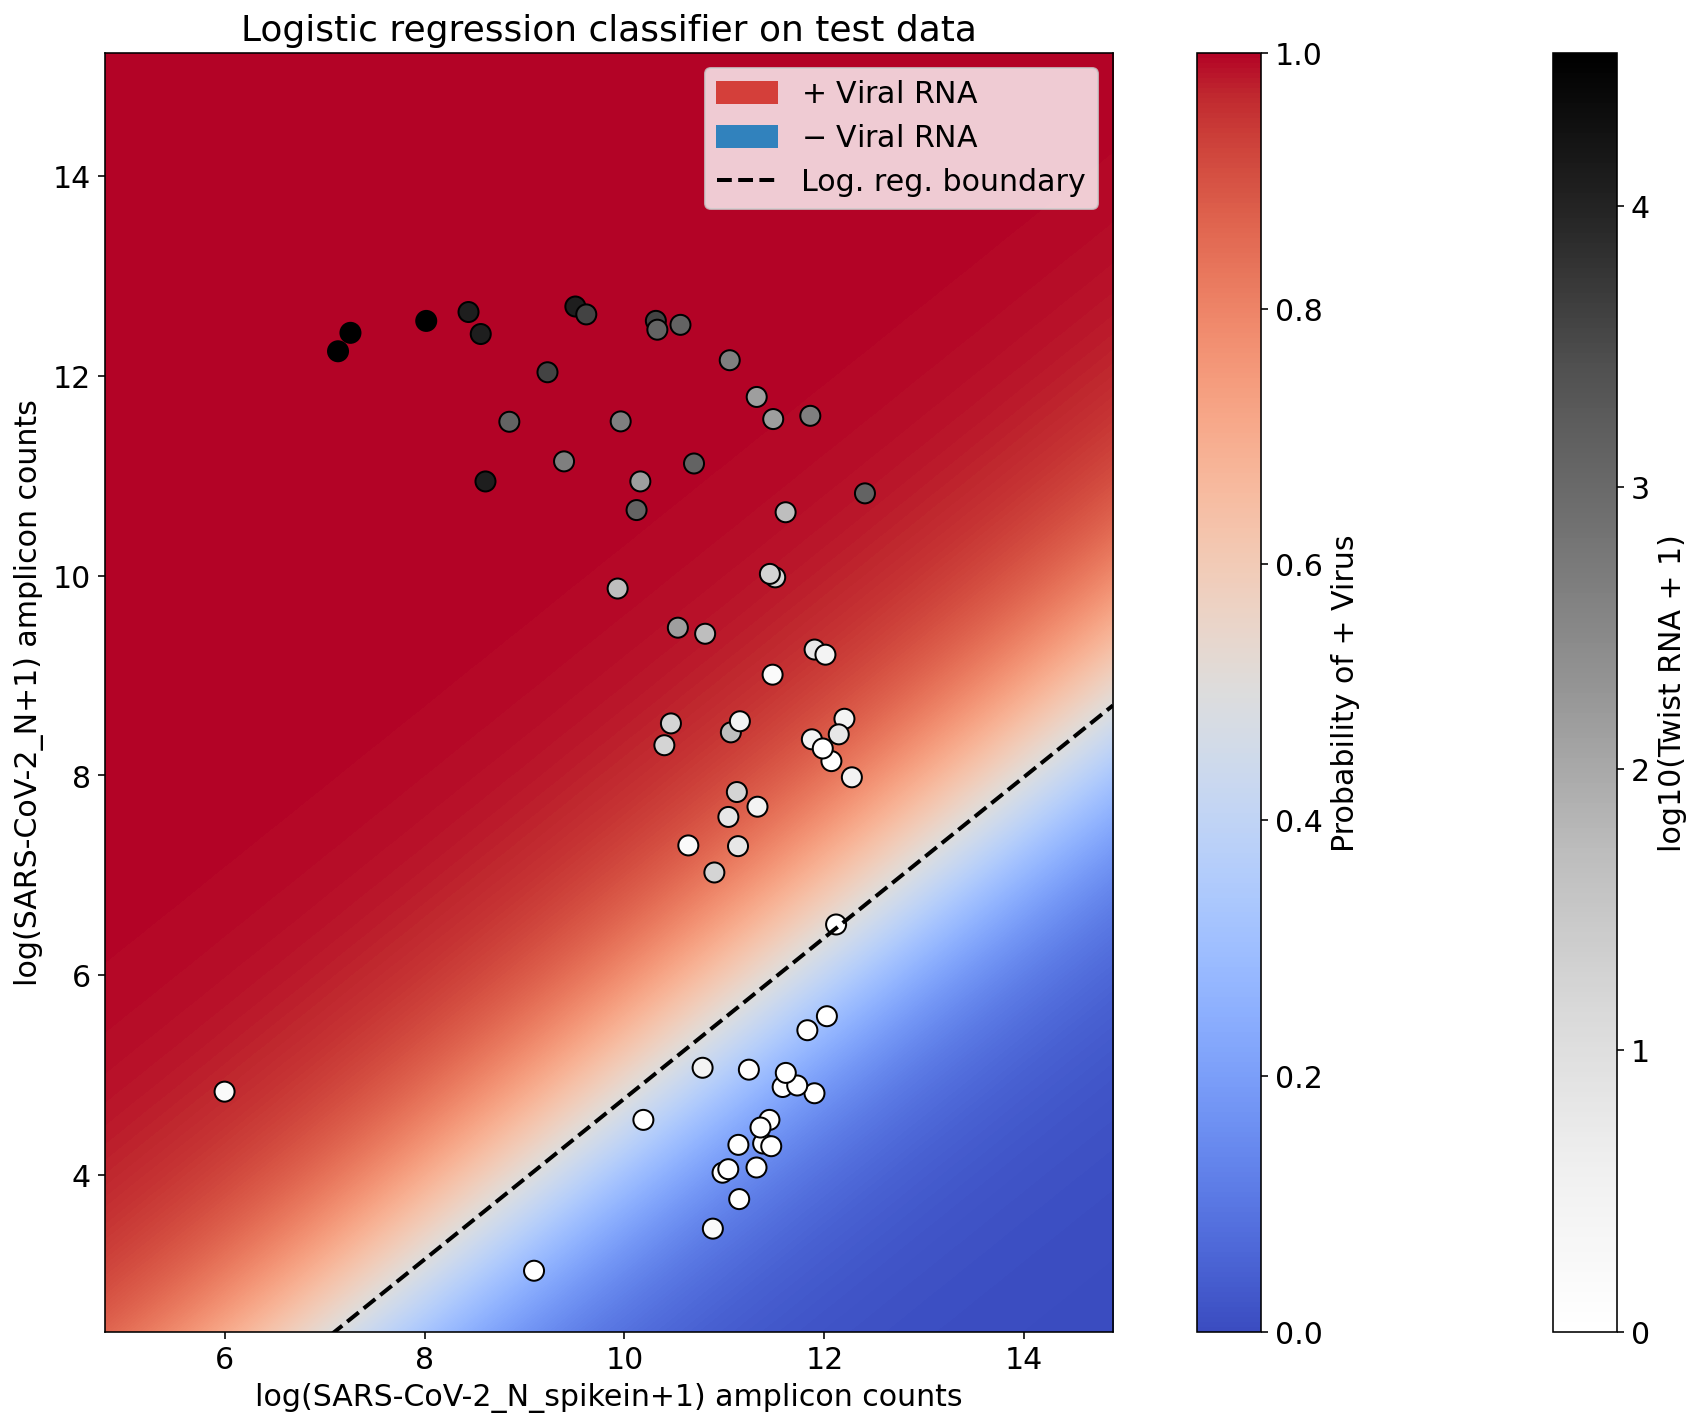

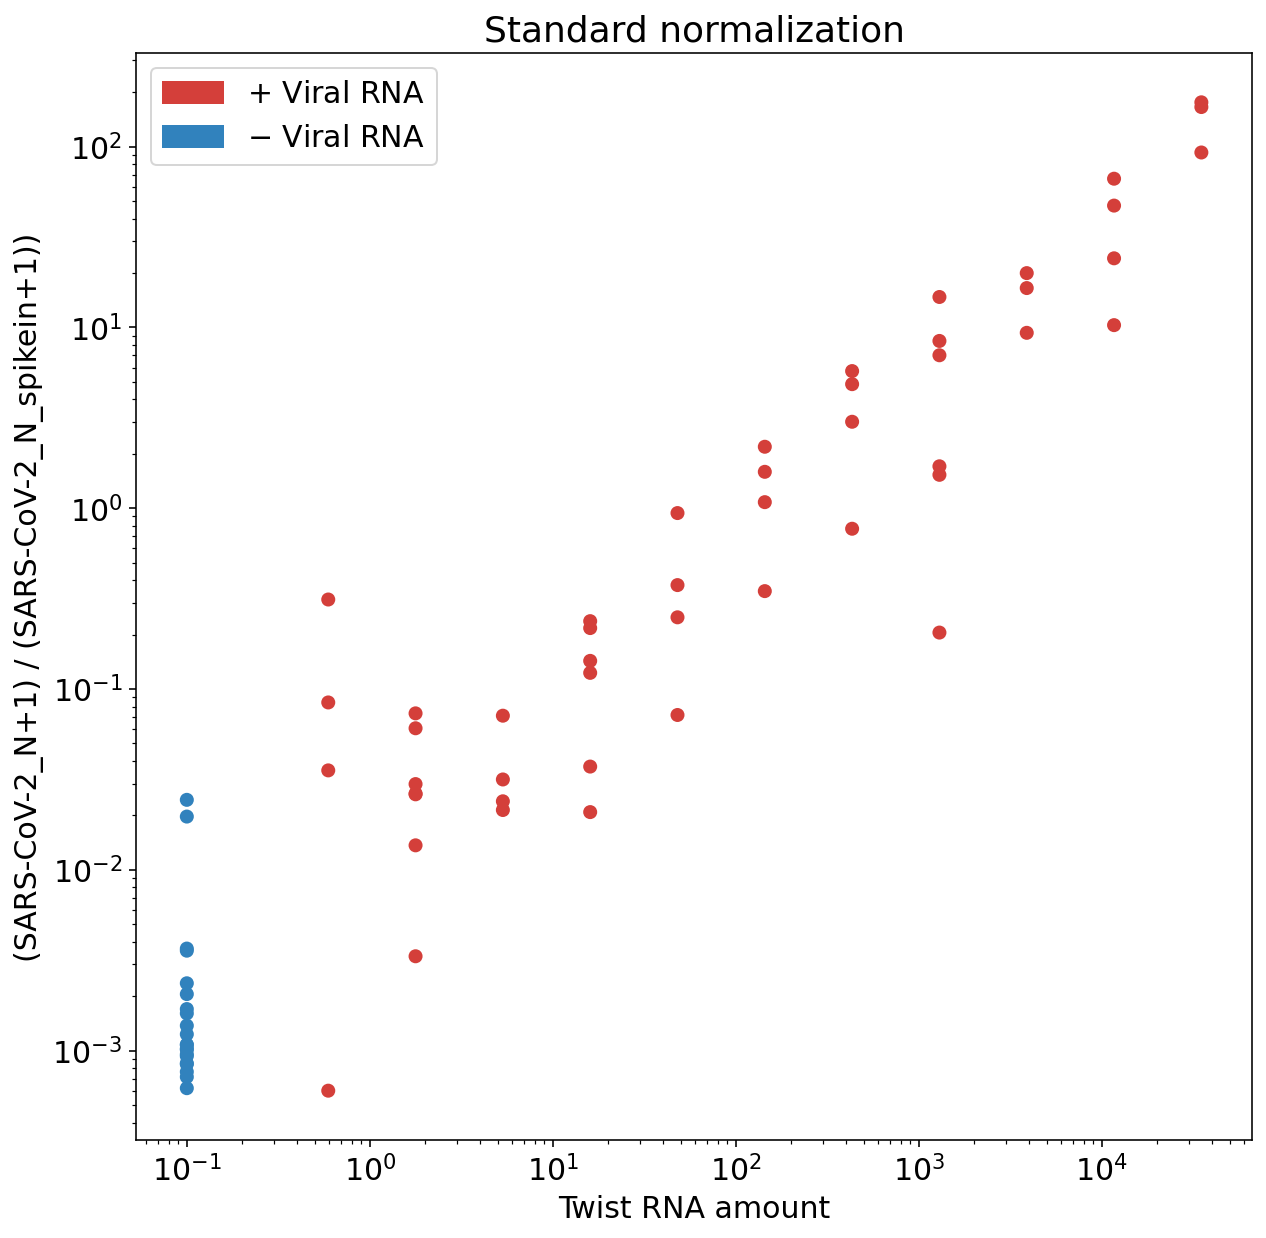

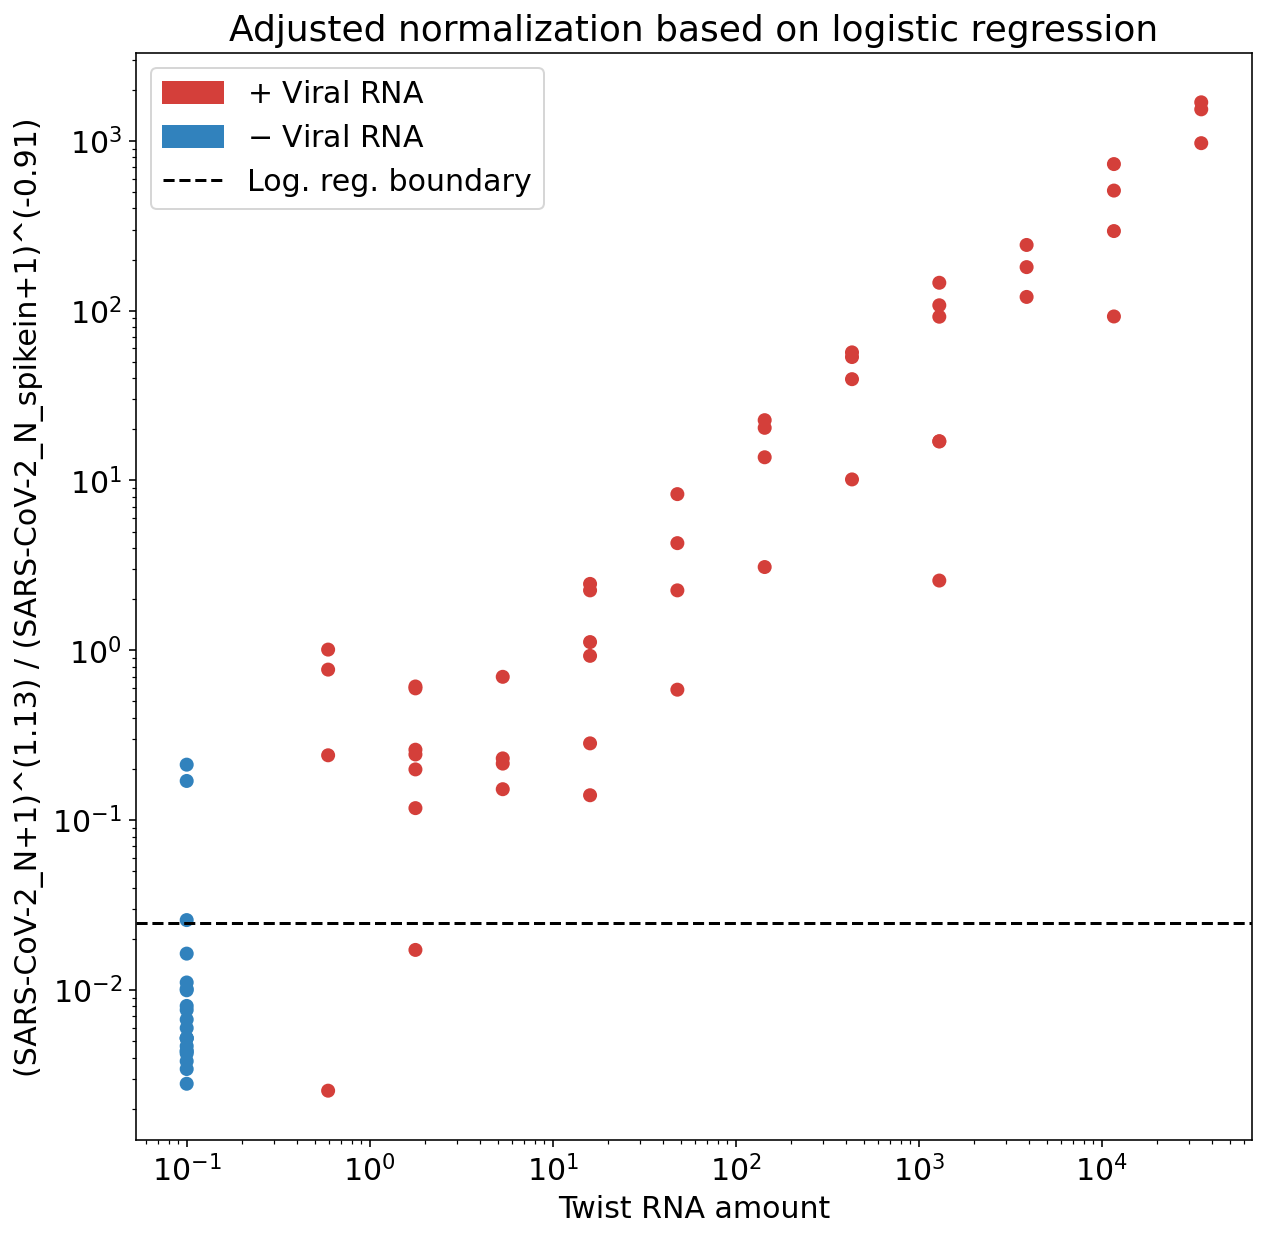

Plate2	HEK293	S	Twist
Score:     0.9583
Precision: 0.9474
Recall:    0.9474


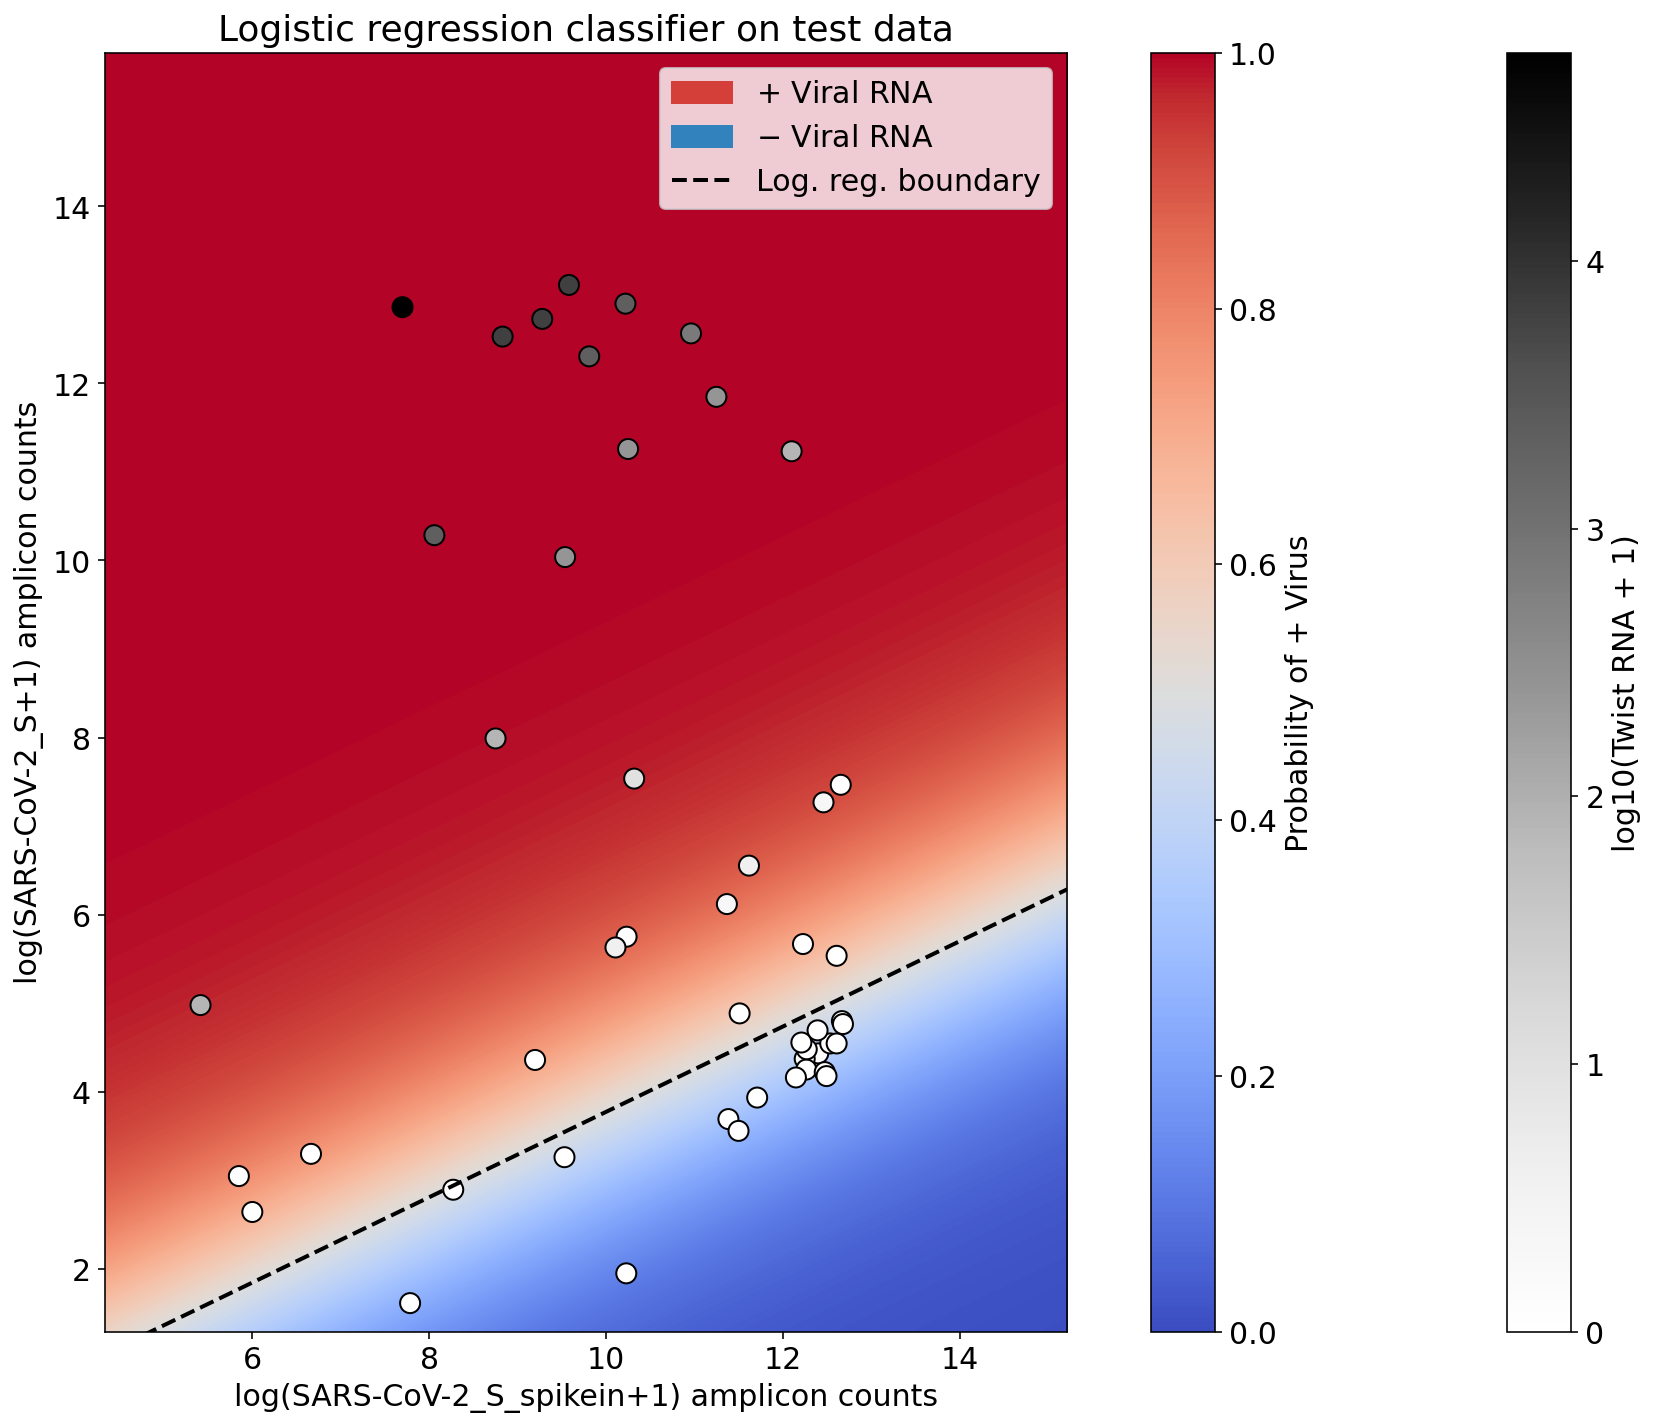

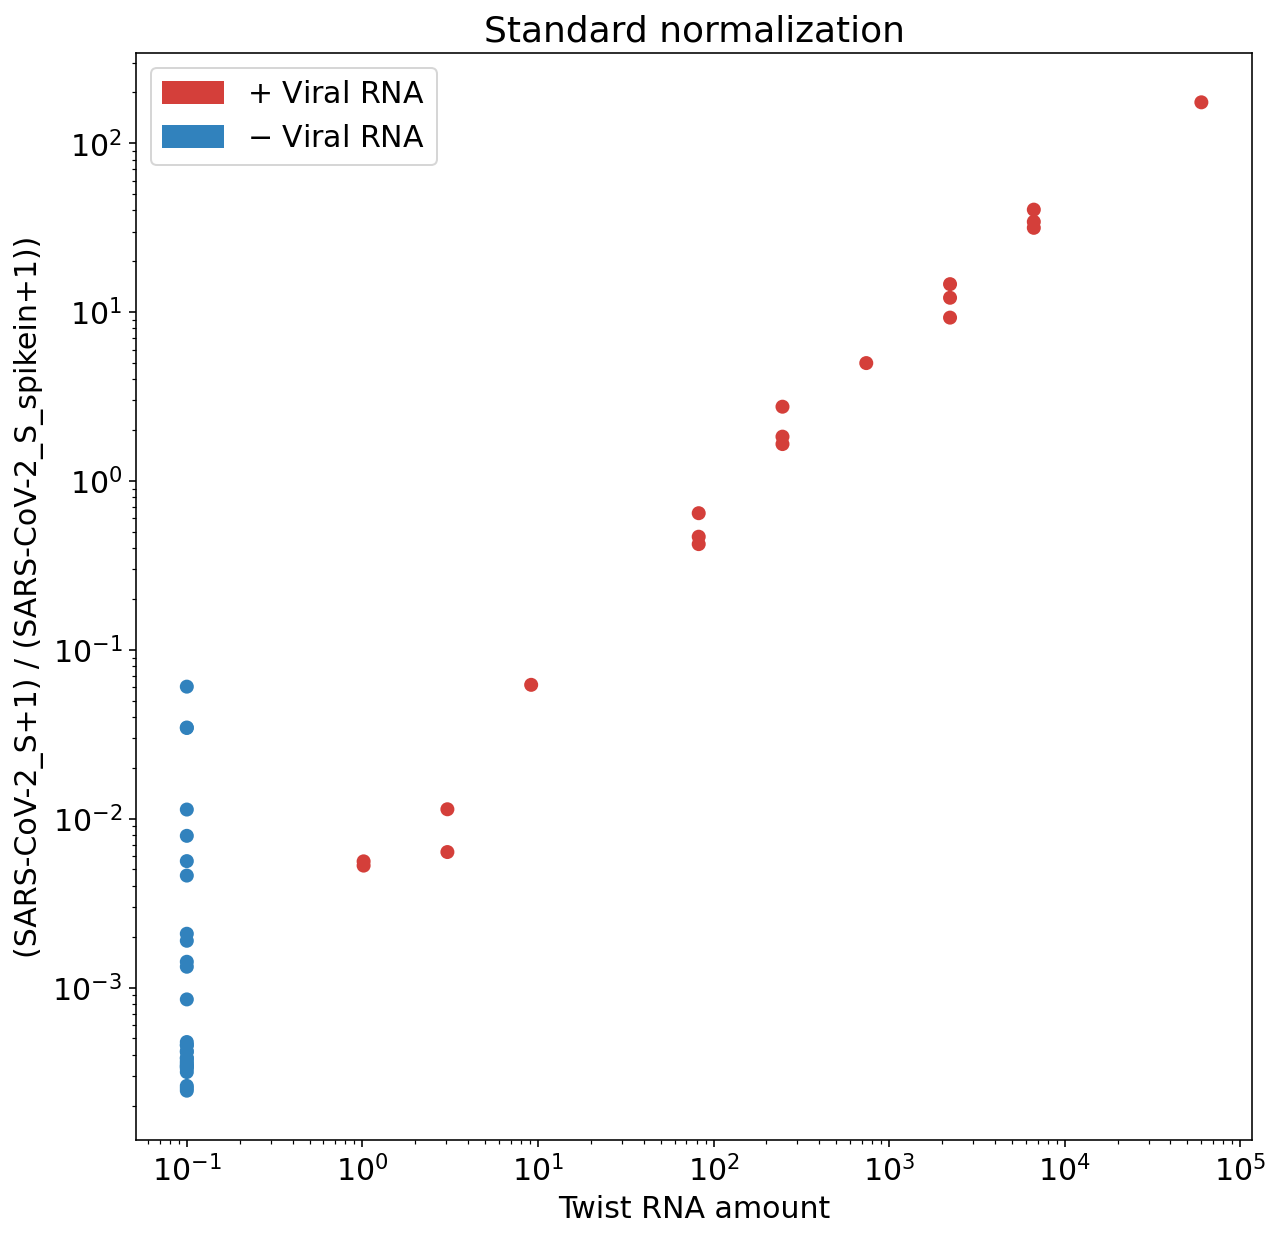

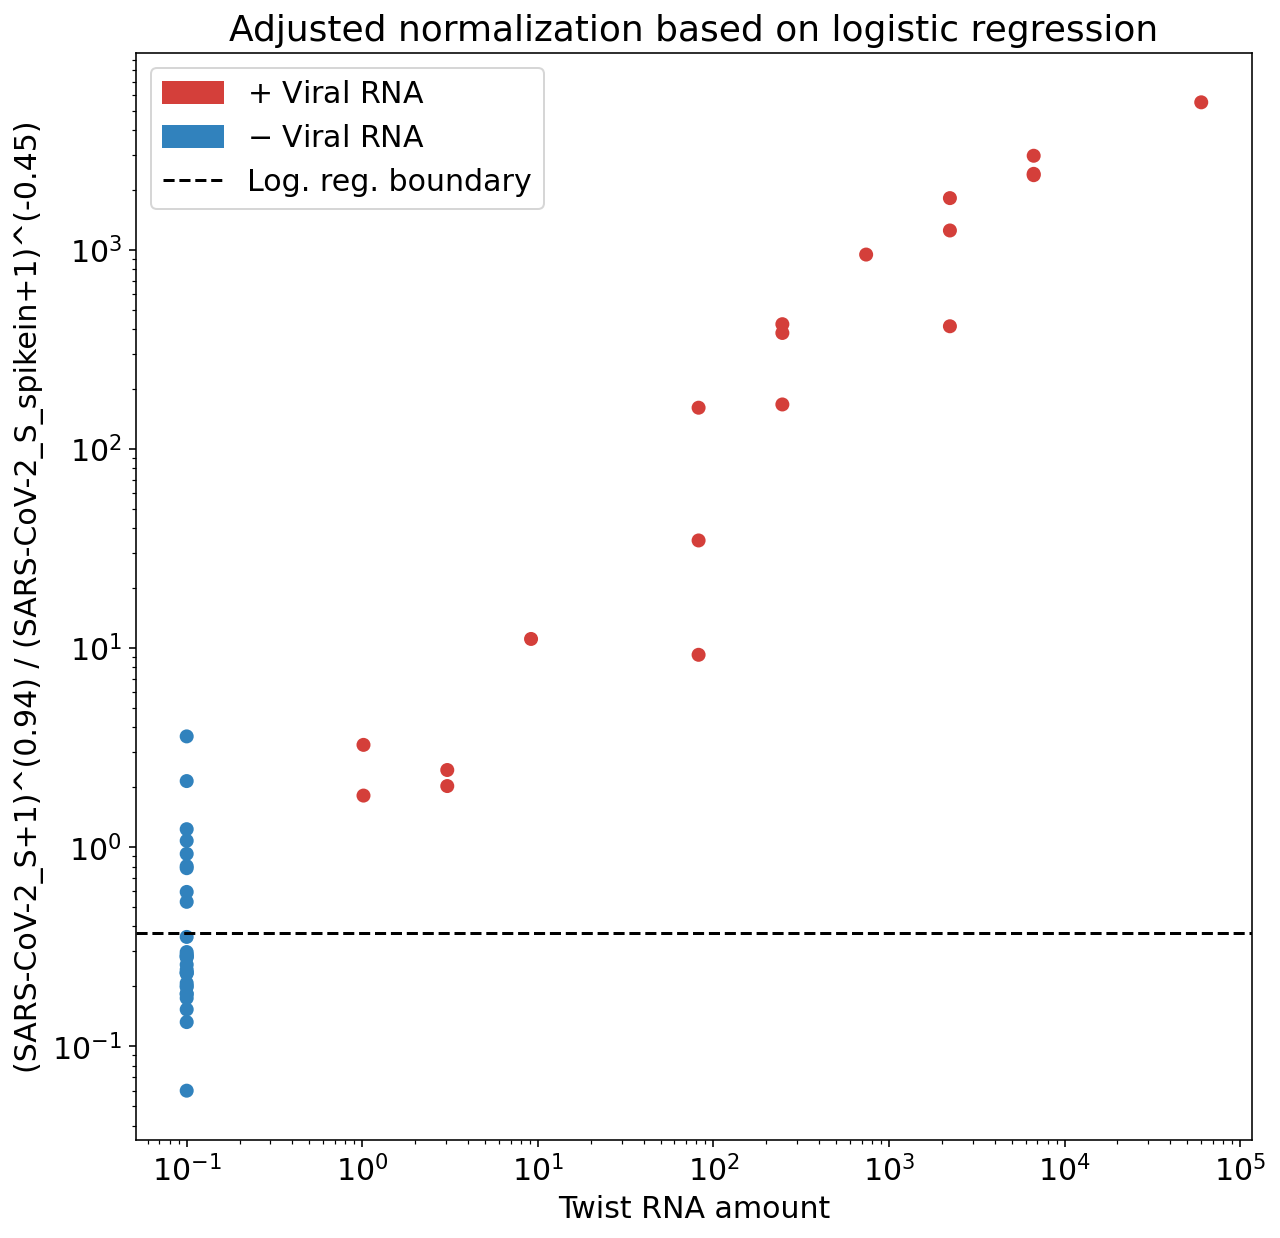

Plate2	HEK293	S	ATCC_RNA
Score:     0.8857
Precision: 0.9767
Recall:    0.8571


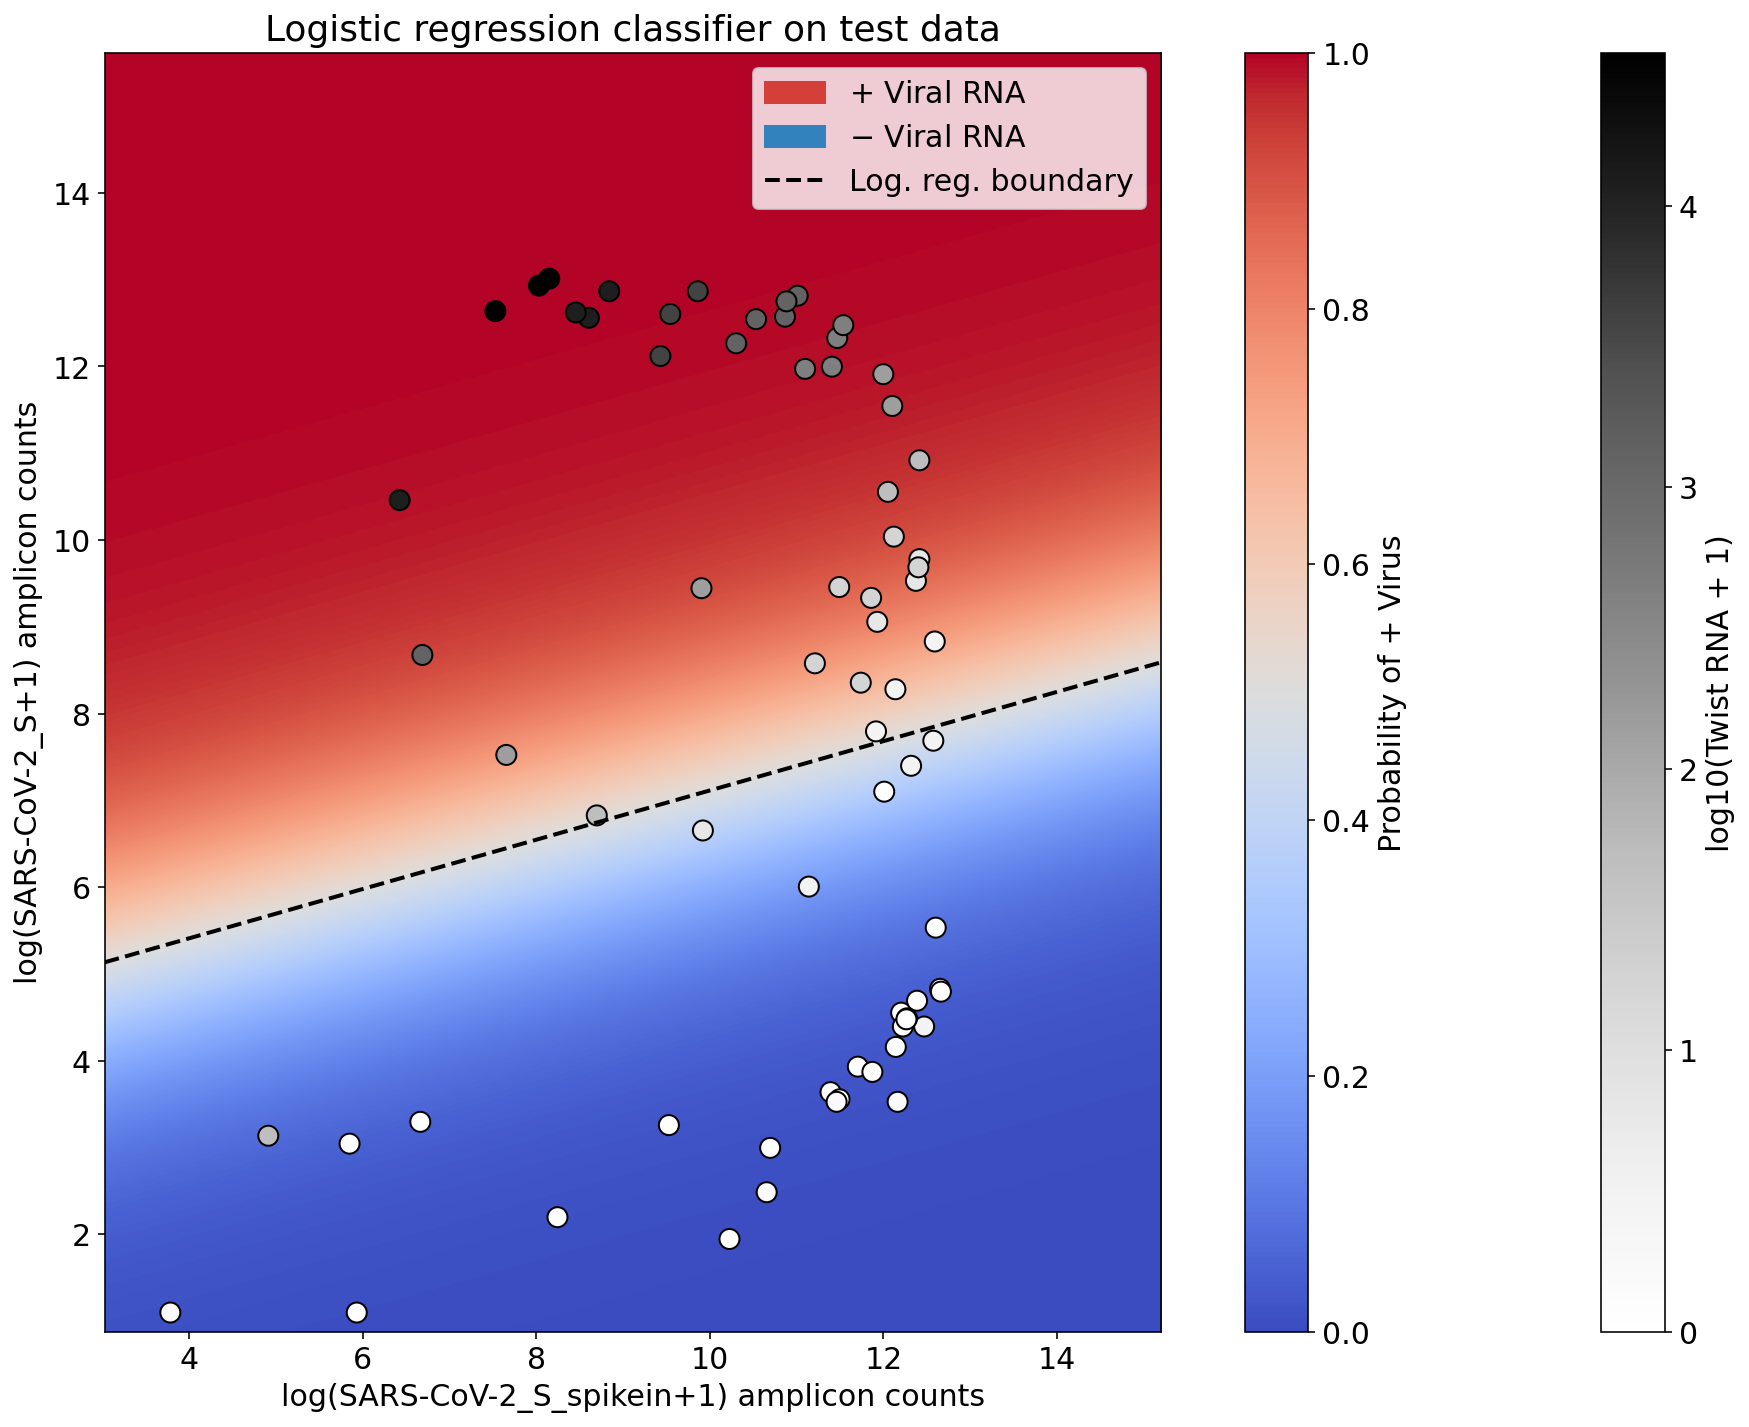

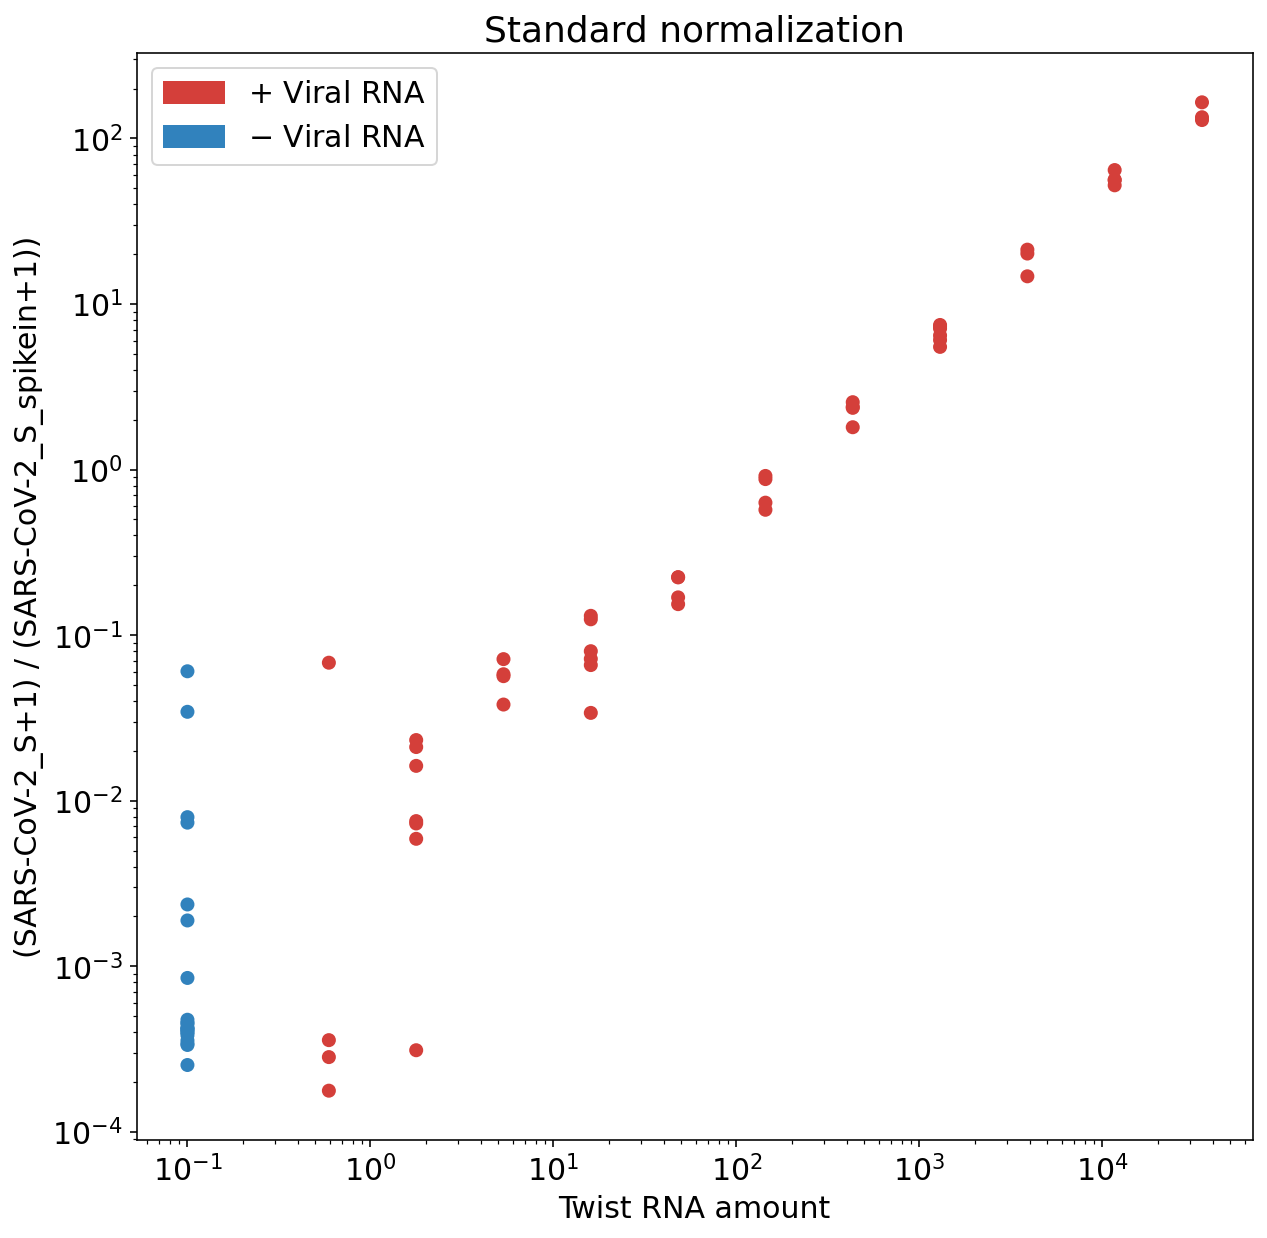

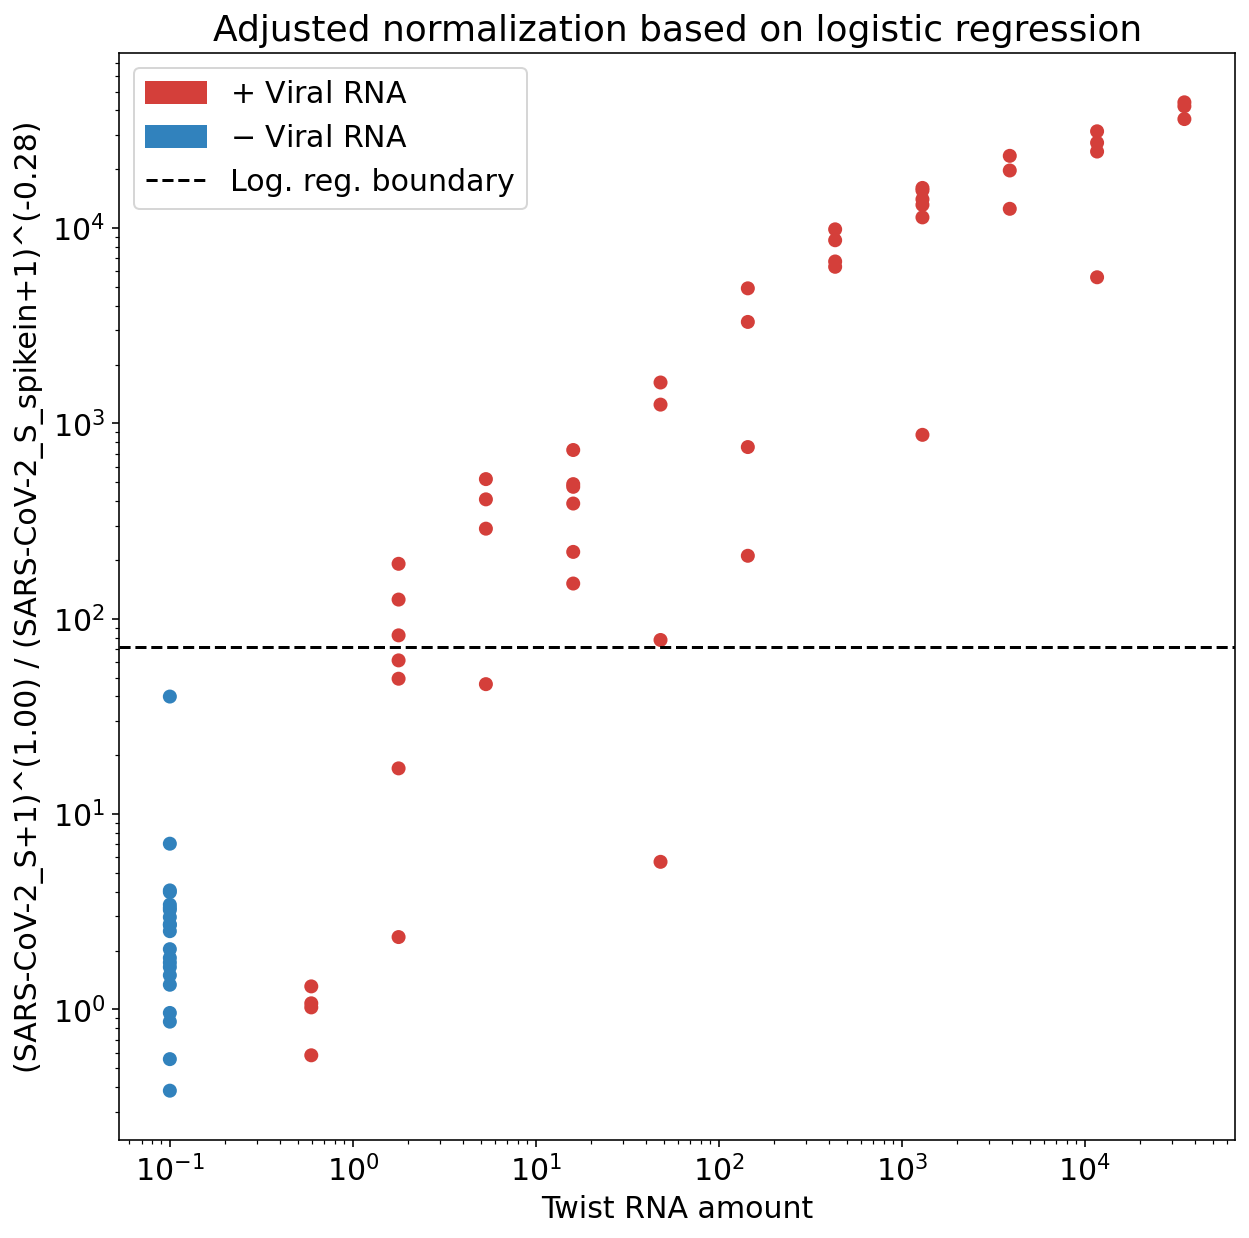

In [81]:
adata = adata[:,adata.var.sort_values("gene").index]
XXX = np.asarray(adata.layers["raw"])
plot_values = []
for (p, l, g, c) in exp:
    pmask = adata.obs.plate.values==p
    cmask = adata.obs[c+"_bool"].values
    lmask = adata.obs.lysate.values==l
    
    m = np.logical_and(np.logical_and(pmask, cmask), lmask)
    vm = np.logical_or(adata.var.gene.str.contains("_"+g), adata.var.gene.str.contains("RPP30")).values
    gene_labels = adata.var.gene.values
    
    XX = XXX[m][:,vm]

    X = np.log1p(XX)
    y1 = nd((adata.obs[m][c]>0).astype(int))
    y2 = nd(adata.obs[m][c].values)

    print("{}\t{}\t{}\t{}".format(p, l, g, c))
    (X_train, X_test, y_train, y_test, y_pred, w, b) = main(X, y1, y2)
    ##########################################################    
    fig, ax = plt.subplots(figsize=(15,10))

    xlabel, ylabel = ("SARS-CoV-2_"+g+"_spikein", "SARS-CoV-2_"+g)
    xidx, yidx = (np.where(gene_labels[vm]==xlabel)[0][0], np.where(gene_labels[vm]==ylabel)[0][0])
        
    plot(X_test, y_test, xidx, yidx, xlabel, ylabel, w, b)
    
    plt.show()
    ##########################################################
    fig, ax = plt.subplots(figsize=(10, 10))
    
    plot_LOD_normal(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b)
    plt.show()
    ##########################################################
    fig, ax = plt.subplots(figsize=(10, 10))
    
    plot_LOD_adjusted(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b)
    plt.show()

We will use the RPP30 gene to check that the whitelist barcode has the top most counts compared to its hamming one distance variants. This is a great QC to ensure that there are no problems with the barcodes. Since the reference contains no shared sequences of 11, each "gene" corresponds to one equivalence class. We will use equivalence class 4 which corresponds to the RPP30 gene.

In [82]:
print("This notebook to {:,.2f} minutes to run.".format((time.time()-t0)/60))

This notebook to 40.40 minutes to run.
